# Grid search results analysis

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colormaps, colors, cm
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from PIL import Image
from ttn_torch import TTN, TTNModel
from utils import titanic_features, get_stripeimage_data_loaders
from itertools import combinations
import math
from glob import glob
import os
from tqdm.notebook import tqdm
from time import time

FONTSIZE=14

/home/alberto/.pyenv/versions/3.11.10/envs/ttn/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/home/alberto/.pyenv/versions/3.11.10/envs/ttn/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [2]:
torch.cuda.is_available()

True

In [3]:
datadir = 'data/grid_search3/'

In [4]:
data_df = pd.read_pickle(datadir + 'grid_search.pkl')
data_df['dtype'].astype('str')
data_df.head()

,features,bond_dim,batch_size,initialize,dtype,sweep,map,loss,train_acc,test_acc,train_acc0,test_acc0,time
0,4,2,64,True,torch.float64,True,spin,0.107742,1.0,1.0,0.5001,0.502,57.635793
1,4,2,64,True,torch.float64,True,poly,0.045964,1.0,1.0,0.4177,0.418,58.283001
2,4,2,64,True,torch.float64,False,spin,0.087960,1.0,1.0,0.4999,0.501,72.238933
3,4,2,64,True,torch.float64,False,poly,0.050759,1.0,1.0,0.3644,0.363,71.736683
4,4,2,64,False,torch.float64,True,spin,0.116536,1.0,1.0,0.2529,0.238,57.931522


In [5]:
data_df['test_acc'] = data_df['test_acc'] * 100
data_df['train_acc'] = data_df['train_acc'] * 100
data_df['test_acc0'] = data_df['test_acc0'] * 100
data_df['train_acc0'] = data_df['train_acc0'] * 100
data_df['test_acc_diff'] = data_df['test_acc'] - data_df['test_acc0']

In [6]:
data_df[((data_df['features']==128) & (data_df['test_acc0']>5)) | (data_df['features']!=128)]

,features,bond_dim,batch_size,initialize,dtype,sweep,map,loss,train_acc,test_acc,train_acc0,test_acc0,time,test_acc_diff
0,4,2,64,True,torch.float64,True,spin,1.077418e-01,100.00,100.0,50.01,50.2,57.635793,49.8
1,4,2,64,True,torch.float64,True,poly,4.596382e-02,100.00,100.0,41.77,41.8,58.283001,58.2
2,4,2,64,True,torch.float64,False,spin,8.796005e-02,100.00,100.0,49.99,50.1,72.238933,49.9
3,4,2,64,True,torch.float64,False,poly,5.075927e-02,100.00,100.0,36.44,36.3,71.736683,63.7
4,4,2,64,False,torch.float64,True,spin,1.165358e-01,100.00,100.0,25.29,23.8,57.931522,76.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,128,16,64,True,torch.float32,False,poly,4.634636e+29,0.00,0.0,50.00,50.0,361.654174,-50.0
588,128,16,1024,True,torch.float32,True,spin,1.949865e+01,97.10,97.3,49.58,49.5,29095.082271,47.8
589,128,16,1024,True,torch.float32,True,poly,4.783001e-01,100.00,100.0,50.00,50.0,29888.419024,50.0
590,128,16,1024,True,torch.float32,False,spin,3.188474e+30,2.79,2.5,49.68,49.5,65.490757,-47.0


## computation time

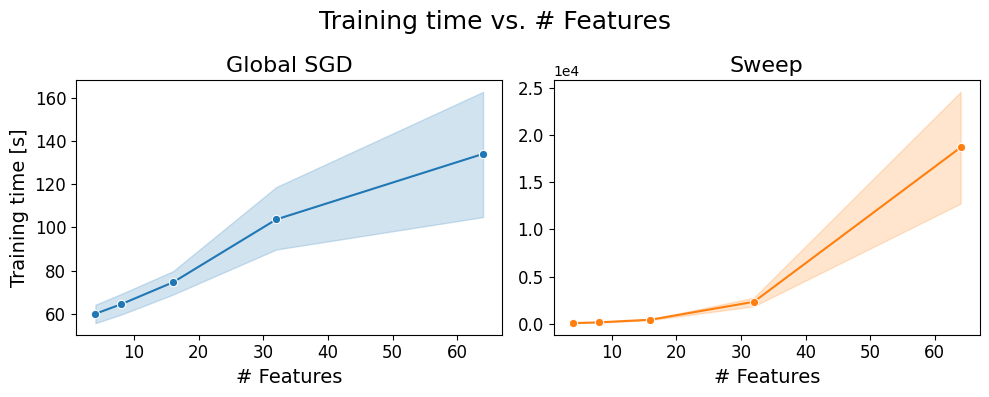

In [9]:
data_df_filtered = data_df[ (data_df['features']<128)]

fig, axs = plt.subplots(1, 2, figsize=(10,4), sharex=True)
#sns.heatmap(data_df_filtered[data_df_filtered['sweep']==False].pivot_table(index='features', columns='bond_dim', values='time', ), ax=axs[0])
sns.lineplot(data_df_filtered[data_df_filtered['sweep']==False], y='time', x='features', ax=axs[0], color='tab:blue', ms=6, marker='o')
sns.lineplot(data_df_filtered[data_df_filtered['sweep']==True], y='time', x='features', ax=axs[1], color='tab:orange', ms=6, marker='o')

axs[0].set_title('Global SGD', fontsize=FONTSIZE+2)
axs[0].set_ylabel('Training time [s]', fontsize=FONTSIZE)
axs[1].set_ylabel('')
axs[1].set_title('Sweep', fontsize=FONTSIZE+2)
axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
for ax in axs:
    ax.set_xlabel('# Features', fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)


#axs[1].set_yscale('function', functions=(lambda x: np.where(x>0, x**(1/4), np.zeros_like(x)), lambda x: x**4))
fig.suptitle('Training time vs. # Features', fontsize=FONTSIZE+4)
fig.tight_layout()
fig.savefig(datadir + 'training_time.pdf')
fig.savefig(datadir + 'training_time.svg')

<Axes: xlabel='bond_dim', ylabel='time'>

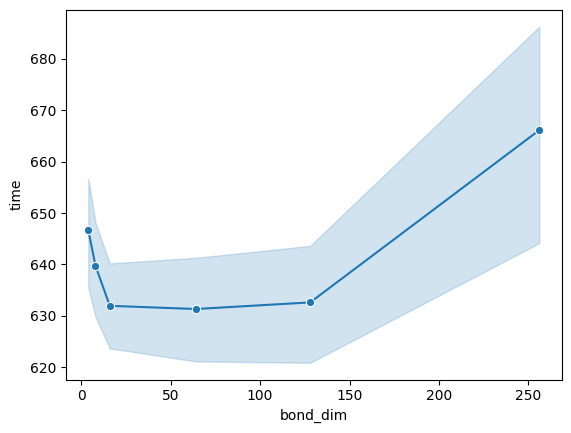

In [16]:
sns.lineplot(data_df_filtered[(data_df_filtered['features']==16) & (data_df_filtered['sweep']==True) & (data_df_filtered['batch_size']==64)], y='time', x='bond_dim', ms=6, marker='o')

## evaluation time

In [6]:
imsize_dict = {4: (2,2), 8: (4, 2), 16: (4, 4), 32: (8, 4), 64: (8, 8), 128: (8, 16)}

In [32]:
models = glob(datadir + 'model_*.npz')
eval_time = []
bds = []
bs = []
fs = []
sizes = []
pbar = tqdm(models)


for model in pbar:
    try:
        ttn = TTNModel.from_npz(model, device='cuda')
        ttn.initialize(False)
        f = ttn.n_features
        b = int(model.split('bs')[1].split('_')[0])
        bd = ttn.bond_dim
        pbar.set_postfix({'features': f, 'bond_dim': bd, 'batch_size': b})
        mapping = model.split('_')[-1][3:7]
        train_dl, test_dl, _ = get_stripeimage_data_loaders(*imsize_dict[f], batch_size=b, dtype=ttn.dtype, mapping=mapping)

        ttn.eval()
        end=0.
        for x, y in test_dl:
            x = x.to('cuda')
            start = time()
            y_pred = ttn(x)
            end += time() - start
        bs.append(b)
        bds.append(bd)
        fs.append(f)
        sizes.append(len(test_dl.dataset))
        eval_time.append(end)
        torch.cuda.empty_cache()
    except KeyboardInterrupt:
        break
    except Exception as e:
        print(e)
        print(model)
        bs.append(0)
        bds.append(0)
        fs.append(0)
        sizes.append(0)
        eval_time.append(0)
        torch.cuda.empty_cache()
        continue

  0%|          | 0/595 [00:00<?, ?it/s]

CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 3.94 GiB of which 1.80 GiB is free. Including non-PyTorch memory, this process has 2.08 GiB memory in use. Of the allocated memory 2.01 GiB is allocated by PyTorch, and 13.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
data/grid_search3/model_f32_bd128_bs1024_iFalse_ttorch.float64_swFalse_mappoly.npz
CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 3.94 GiB of which 1.80 GiB is free. Including non-PyTorch memory, this process has 2.08 GiB memory in use. Of the allocated memory 2.01 GiB is allocated by PyTorch, and 13.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=

In [61]:
eval_df = pd.DataFrame({'features': fs, 'bond_dim': bds, 'batch_size': bs, 'dl_size': sizes, 'eval_time': eval_time})
eval_df = eval_df[eval_df['features']!=0]
eval_df.to_csv(datadir + 'eval_time.csv')

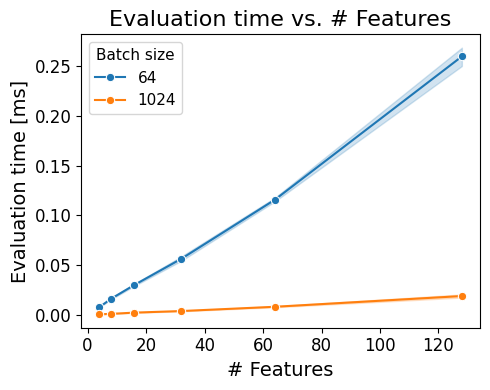

In [7]:
eval_df = pd.read_csv(datadir + 'eval_time.csv')
fig, ax = plt.subplots(1, 1, figsize=(5,4))
eval_df['time_per_sample'] = eval_df['eval_time'] / eval_df['dl_size'] *1000
sns.lineplot(data=eval_df, x='features', y='time_per_sample', hue='batch_size', palette=['tab:blue', 'tab:orange'], marker='o', ms=6, ax=ax)

ax.set_xlabel('# Features', fontsize=FONTSIZE)
ax.set_ylabel('Evaluation time [ms]', fontsize=FONTSIZE)
ax.set_title('Evaluation time vs. # Features', fontsize=FONTSIZE+2)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.legend(title='Batch size', fontsize=FONTSIZE-3, title_fontsize=FONTSIZE-3)
#ax.set_yscale('function', functions=(lambda x: np.where(x>0, x**(1/1.2), np.zeros_like(x)), lambda x: x**1.2))

fig.tight_layout()
fig.savefig(datadir + 'eval_time.pdf')
fig.savefig(datadir + 'eval_time.svg')

<Axes: xlabel='bond_dim', ylabel='eval_time'>

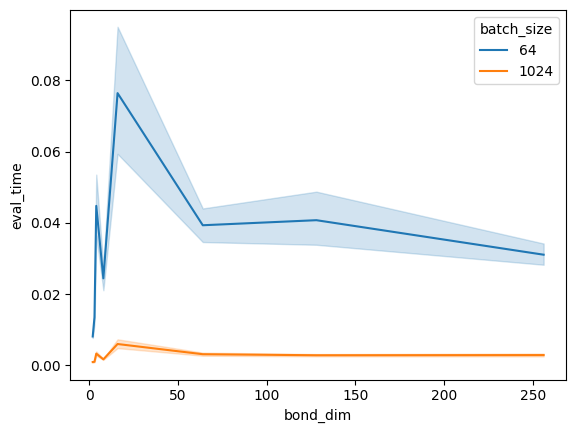

In [54]:
sns.lineplot(data=eval_df, x='bond_dim', y='eval_time', hue='batch_size', palette=['tab:blue', 'tab:orange'])

## float vs complex

In [7]:
# divide float and complex
float_df = data_df[data_df['dtype'] == 'torch.float64'].drop(columns=['dtype'])
complex_df = data_df[data_df['dtype'] == 'torch.complex128'].drop(columns=['dtype'])

float_df.head()

,features,bond_dim,batch_size,initialize,sweep,map,loss,train_acc,test_acc,train_acc0,test_acc0,time,test_acc_diff
0,4,2,64,True,True,spin,0.107742,100.0,100.0,50.01,50.2,57.635793,49.8
1,4,2,64,True,True,poly,0.045964,100.0,100.0,41.77,41.8,58.283001,58.2
2,4,2,64,True,False,spin,0.087960,100.0,100.0,49.99,50.1,72.238933,49.9
3,4,2,64,True,False,poly,0.050759,100.0,100.0,36.44,36.3,71.736683,63.7
4,4,2,64,False,True,spin,0.116536,100.0,100.0,25.29,23.8,57.931522,76.2


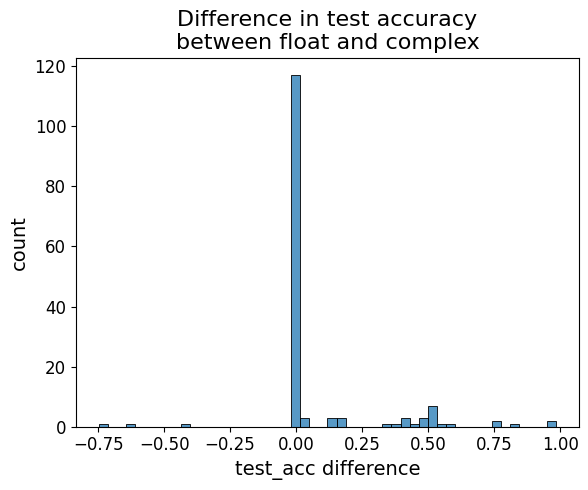

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.histplot(float_df.set_index(['features', 'bond_dim', 'batch_size', 'initialize'])['test_acc'] - complex_df.set_index(['features', 'bond_dim', 'batch_size', 'initialize'])['test_acc'], bins=50, ax=ax)
ax.set_title('Difference in test accuracy\nbetween float and complex', fontsize=FONTSIZE+2)
ax.set_xlabel('test_acc difference', fontsize=FONTSIZE)
ax.set_ylabel('count', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()

fig.savefig('data/grid_search/float_complex_diff.png', dpi=600)

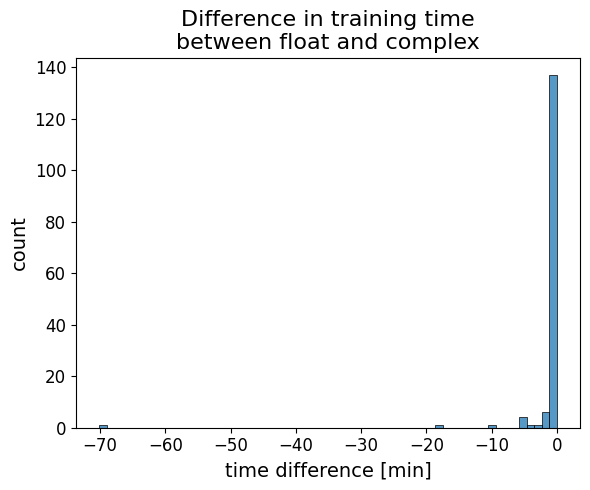

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.histplot((float_df.set_index(['features', 'bond_dim', 'batch_size', 'initialize'])['time'] - complex_df.set_index(['features', 'bond_dim', 'batch_size', 'initialize'])['time']) / 60., bins=60, ax=ax)
ax.set_title('Difference in training time\nbetween float and complex', fontsize=FONTSIZE+2)
ax.set_xlabel('time difference [min]', fontsize=FONTSIZE)
ax.set_ylabel('count', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()

fig.savefig('data/grid_search/float_complex_timediff.png', dpi=600)

## Initialization

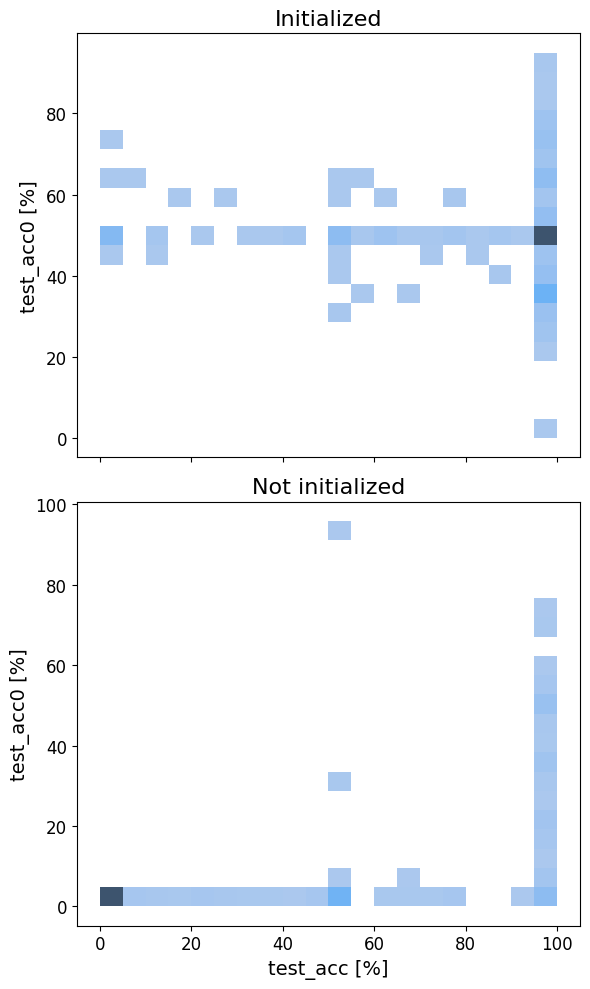

In [52]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10), sharex=True)
df_initTrue = data_df[data_df['initialize'] == True].copy()
df_initFalse = data_df[data_df['initialize'] == False].copy()
df_initTrue['diff'] = df_initTrue['test_acc'] - df_initTrue['test_acc0']
df_initFalse['diff'] = df_initFalse['test_acc'] - df_initFalse['test_acc0']
sns.histplot(df_initTrue[['test_acc', 'test_acc0']], x = 'test_acc', y='test_acc0', bins=20, ax=ax[0])
sns.histplot(df_initFalse[['test_acc','test_acc0']], x = 'test_acc', y='test_acc0', bins=20, ax=ax[1])
ax[0].set_title('Initialized', fontsize=FONTSIZE+2)
ax[1].set_title('Not initialized', fontsize=FONTSIZE+2)
ax[1].set_xlabel('test_acc [%]', fontsize=FONTSIZE)
ax[0].set_ylabel('test_acc0 [%]', fontsize=FONTSIZE)
ax[1].set_ylabel('test_acc0 [%]', fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
ax[1].tick_params(labelsize=FONTSIZE-2)

#fig.suptitle('Difference in test accuracy\nafter and before training', fontsize=FONTSIZE+2)
fig.tight_layout()

fig.savefig(datadir + 'init_diff.pdf')

In [9]:
def violinplot(data, x, y, ax, fix: dict = {}, **kwargs):
    data_to_plot = data.copy()
    if len(fix):
        data_to_plot = data_to_plot.query(' and '.join([f'{k} == {v}' for k, v in fix.items()]))

    sns.violinplot(data=data_to_plot, x=x, y=y, ax=ax, **kwargs)
    ax.set_xlabel(x, fontsize=FONTSIZE)
    ax.set_ylabel(y, fontsize=FONTSIZE)
    ax.tick_params(labelsize=FONTSIZE-2)

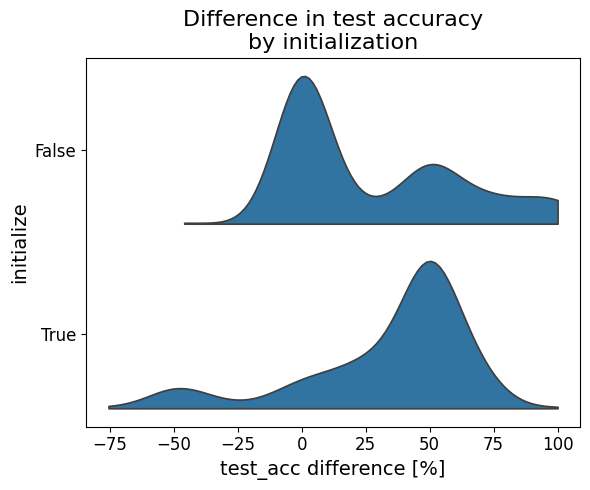

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
violinplot(data=data_df, y='initialize', x='test_acc_diff', orient='h', inner=None, split=True, cut = 0, ax=ax)
ax.set_title('Difference in test accuracy\nby initialization', fontsize=FONTSIZE+2)
ax.set_xlabel('test_acc difference [%]', fontsize=FONTSIZE)

fig.tight_layout()
fig.savefig(datadir + 'init_diff_violin.pdf')

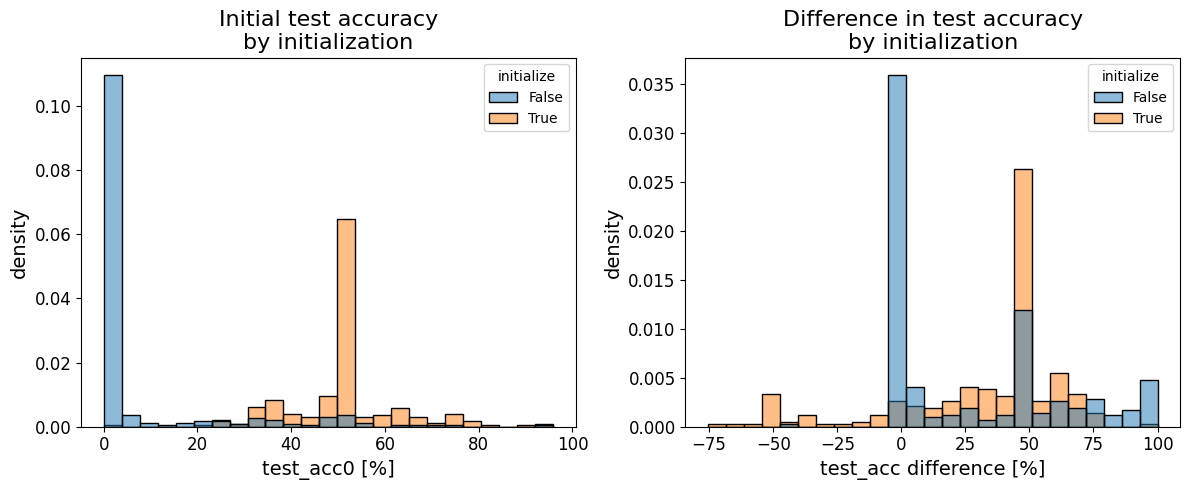

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=data_df, x='test_acc0', hue='initialize', stat='density', bins=25, ax=axs[0])
ax = axs[0]
ax.set_title('Initial test accuracy\nby initialization', fontsize=FONTSIZE+2)
ax.set_xlabel('test_acc0 [%]', fontsize=FONTSIZE)
ax.set_ylabel('density', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)


sns.histplot(data=data_df, x='test_acc_diff', hue='initialize', stat='density', bins=25, ax=axs[1])
ax = axs[1]
ax.set_title('Difference in test accuracy\nby initialization', fontsize=FONTSIZE+2)
ax.set_xlabel('test_acc difference [%]', fontsize=FONTSIZE)
ax.set_ylabel('density', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)

fig.tight_layout()
fig.savefig(datadir + 'init_diff_hist.pdf')

In [32]:
data_df[data_df['initialize'] == False]['test_acc_diff'].median()

2.5

## Sweeping

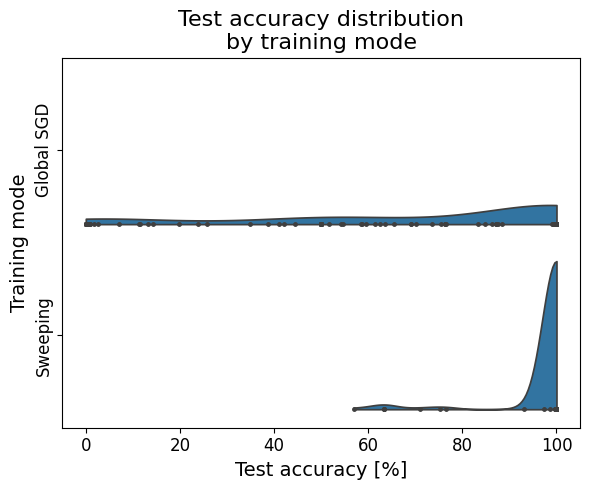

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fix = {'initialize': True}

violinplot(data_df, 'test_acc', 'sweep', ax, fix=fix, orient='h', inner='point', split=True, cut=0)
ax.set_title('Test accuracy distribution\nby training mode', fontsize=FONTSIZE+2)
ax.set_ylabel('Training mode', fontsize=FONTSIZE)
ax.set_xlabel('Test accuracy [%]', fontsize=FONTSIZE)
ax.set_yticks(ax.get_yticks(), ['Global SGD', 'Sweeping'], fontsize=FONTSIZE-2, rotation=90, va='center')
ax.tick_params(labelsize=FONTSIZE-2)

fig.tight_layout()
fig.savefig(datadir + 'sweep_violin_' + '_'.join([str(key)+str(value) for key, value in fix.items()]) + '.pdf')

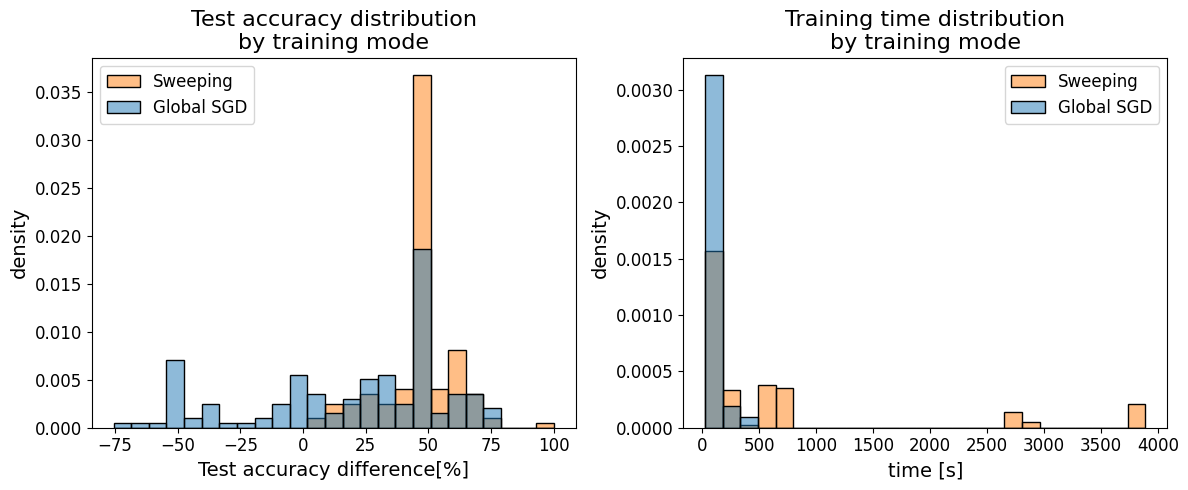

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fix = {'initialize': True}
data_to_plot = data_df.copy()
if len(fix):
    data_to_plot = data_to_plot.query(' and '.join([f'{k} == {v}' for k, v in fix.items()]))

ax = axs[0]
sns.histplot(data=data_to_plot, x='test_acc_diff', hue='sweep', stat='density', bins=25, ax=ax)
ax.set_title('Test accuracy distribution\nby training mode', fontsize=FONTSIZE+2)
ax.set_ylabel('density', fontsize=FONTSIZE)
ax.set_xlabel('Test accuracy difference[%]', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)
ax.legend(labels=['Sweeping', 'Global SGD'], fontsize=FONTSIZE-2)

ax = axs[1]
sns.histplot(data=data_to_plot[data_to_plot['time'] < 5000], x='time', hue='sweep', stat='density', bins=25, ax=ax)
ax.set_title('Training time distribution\nby training mode', fontsize=FONTSIZE+2)
ax.set_ylabel('density', fontsize=FONTSIZE)
ax.set_xlabel('time [s]', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)
ax.legend(['Sweeping', 'Global SGD'], fontsize=FONTSIZE-2)

fig.tight_layout()
fig.savefig(datadir + 'sweep_hist_' + '_'.join([str(key)+str(value) for key, value in fix.items()]) + '.pdf')

In [37]:
data_to_plot.groupby('sweep')['test_acc_diff'].median()

sweep
False    33.1
True     50.0
Name: test_acc_diff, dtype: float64

In [40]:
data_to_plot.groupby(['sweep', 'features'])['time']

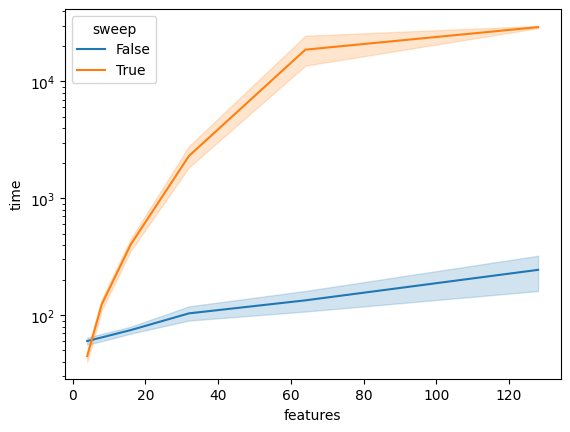

In [45]:
sns.lineplot(data=data_df, x='features', y='time', hue='sweep')
plt.yscale('log')

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: title={'center': 'features vs sweep'}, xlabel='sweep', ylabel='features'>],
       dtype=object))

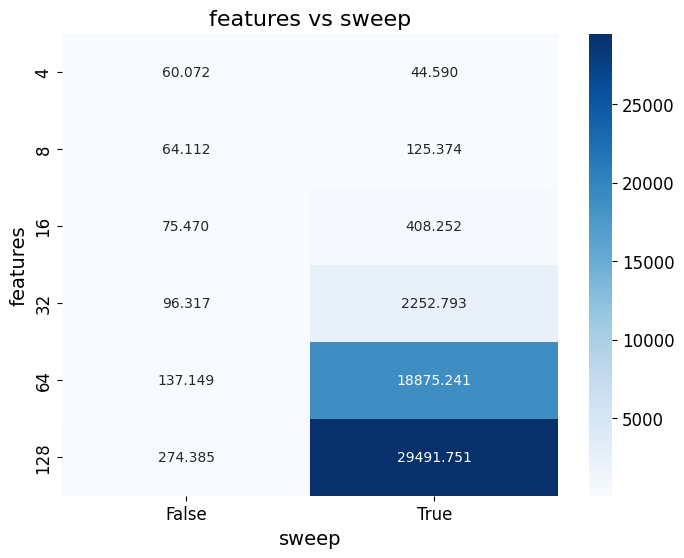

In [42]:
heat_pairplot(data_to_plot, ['features', 'sweep'], 'time')

## Dtype

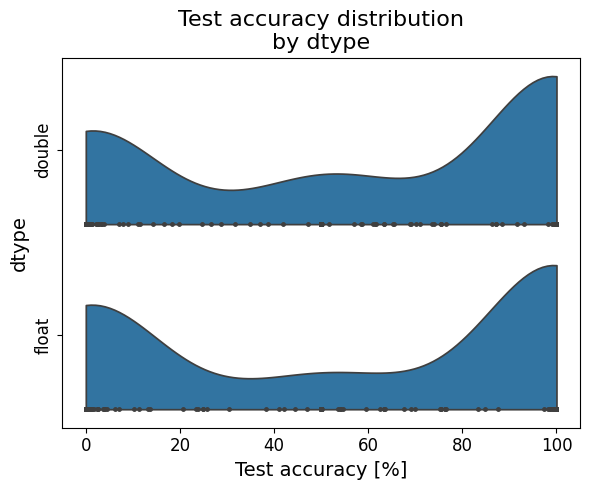

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
violinplot(data_df, 'test_acc', 'dtype', ax, fix={}, orient='h', inner='point', split=True, cut=0)
ax.set_title('Test accuracy distribution\nby dtype', fontsize=FONTSIZE+2)
ax.set_xlabel('Test accuracy [%]', fontsize=FONTSIZE)
ax.set_yticks(ax.get_yticks(), ['double', 'float'], fontsize=FONTSIZE-2, rotation=90, va='center')

fig.tight_layout()
fig.savefig(datadir + 'dtype_violin.pdf')

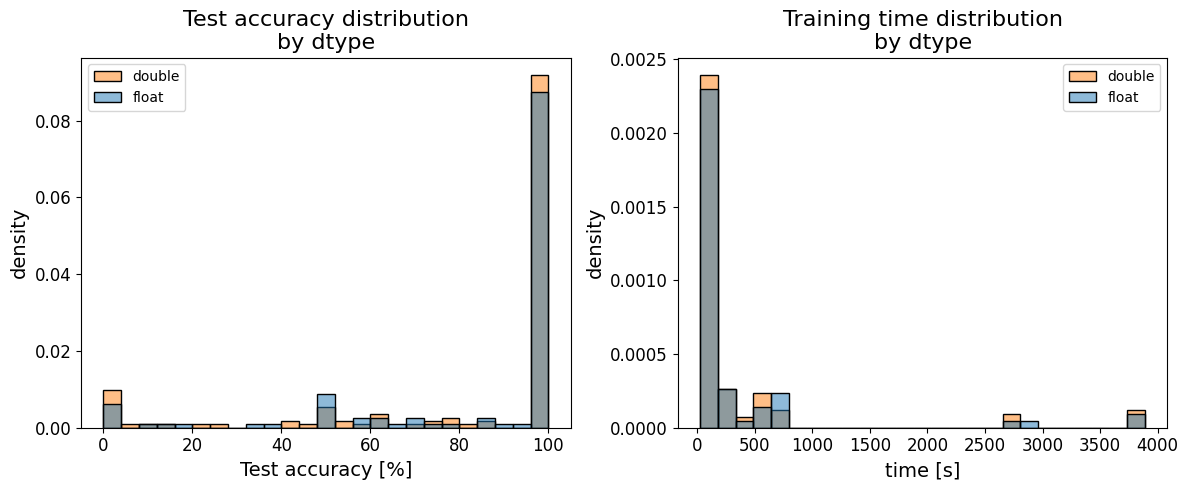

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fix={'initialize': True}
data_to_plot = data_df.copy()
if len(fix):
    data_to_plot = data_to_plot.query(' and '.join([f'{k} == {v}' for k, v in fix.items()]))


ax = axs[0]
sns.histplot(data=data_to_plot, x='test_acc', hue='dtype', stat='density', bins=25, ax=ax)
ax.set_title('Test accuracy distribution\nby dtype', fontsize=FONTSIZE+2)
ax.set_xlabel('Test accuracy [%]', fontsize=FONTSIZE)
ax.set_ylabel('density', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)
ax.legend(['double', 'float'])

ax = axs[1]
sns.histplot(data=data_to_plot[data_to_plot['time'] < 5000], x='time', hue='dtype', stat='density', bins=25, ax=ax)
ax.set_title('Training time distribution\nby dtype', fontsize=FONTSIZE+2)
ax.set_xlabel('time [s]', fontsize=FONTSIZE)
ax.set_ylabel('density', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)
ax.legend(['double', 'float'])

fig.tight_layout()
fig.savefig(datadir + 'dtype_hist.pdf')

## confusion matrices

In [41]:
def heat_pairplot(df, variables, value='train_acc', fix={}, fmt='.3f', cmap='Blues', ax=None, **kwargs):
    # get all combinations of variables
    variables = [v for v in variables if v not in fix.keys()]
    pairs = list(combinations(variables, 2))

    rows = math.floor(len(pairs)**0.5)
    cols = math.ceil(len(pairs)/rows)
    if ax is None:
        fig, ax = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))
    else:
        fig = ax.get_figure()
    if len(pairs) == 1:
        ax = np.array([ax])
    else:
        ax = ax.flatten()

    df_plot = df.copy()
    if len(fix):
        df_plot = df_plot.query(' and '.join([f'{k} == {v}' for k, v in fix.items()]))

    # plot
    for i, combo in enumerate(pairs):
        sns.heatmap(df_plot.pivot_table(index=combo[0], columns=combo[1], values=value, aggfunc='mean'), ax=ax[i], annot=True, fmt=fmt, cmap=cmap, **kwargs)
        ax[i].set_title(f'{combo[0]} vs {combo[1]}', fontsize=FONTSIZE+2)
        ax[i].set_xlabel(combo[1], fontsize=FONTSIZE)
        ax[i].set_ylabel(combo[0], fontsize=FONTSIZE)
        ax[i].tick_params(labelsize=FONTSIZE-2)
        ax[i].collections[0].colorbar.ax.tick_params(labelsize=FONTSIZE-2)

    return fig, ax

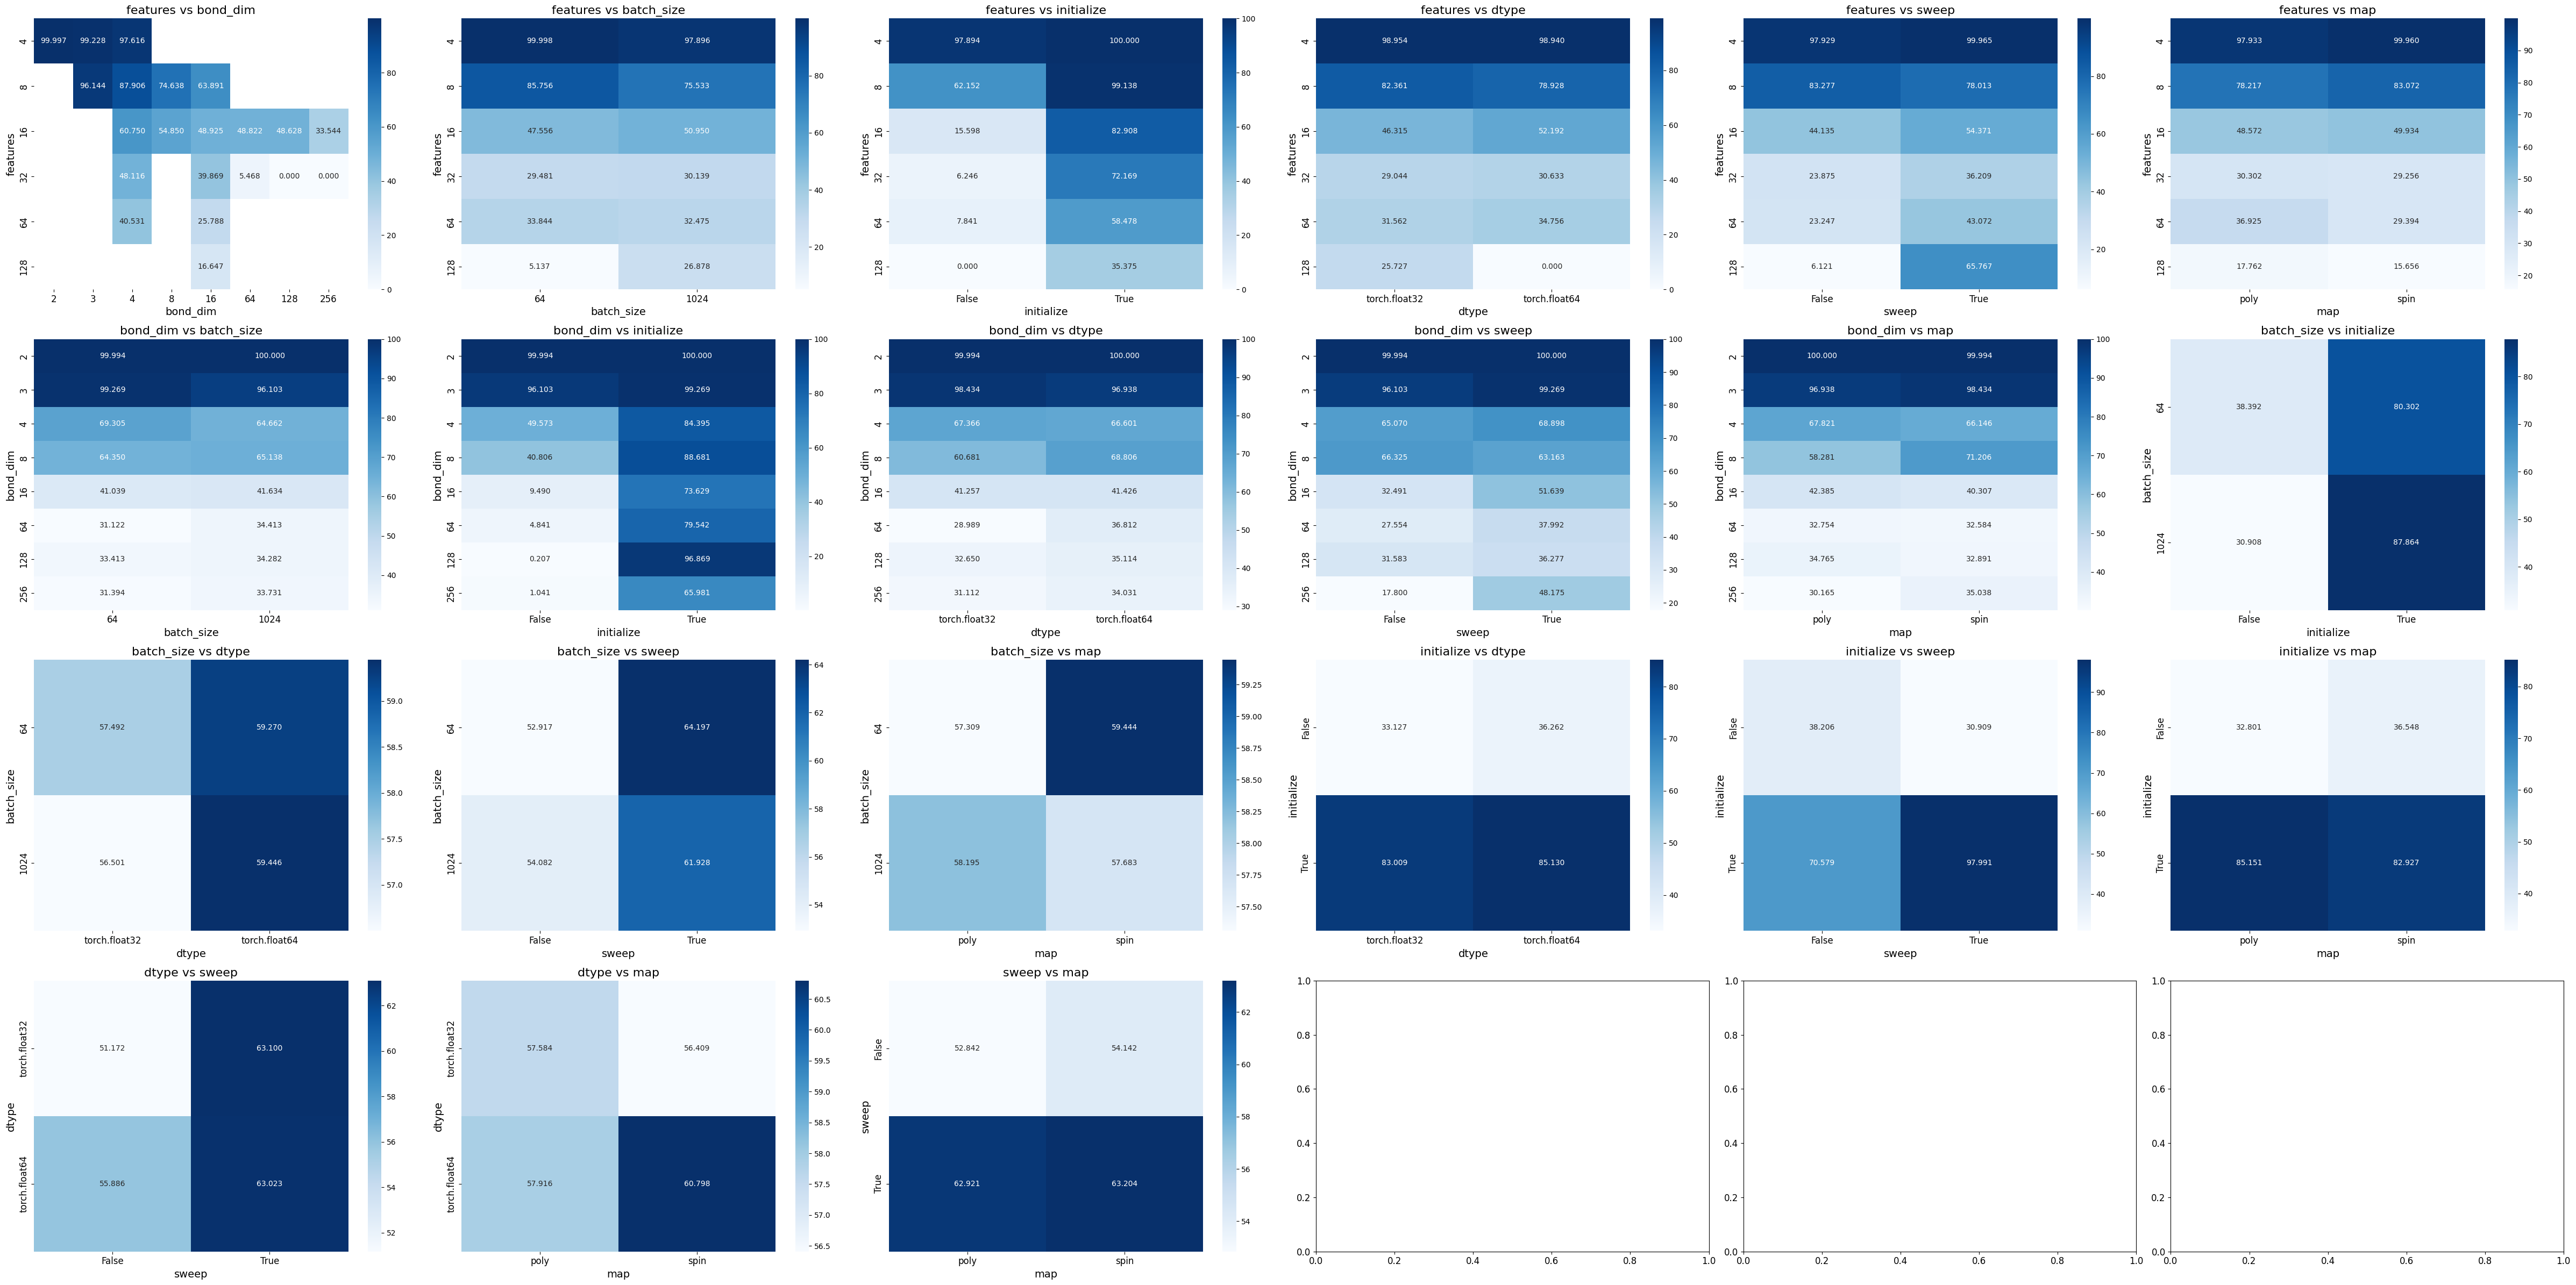

In [157]:
# plot heatmaps

fig, ax = heat_pairplot(data_df, data_df.columns[:7], 'test_acc')
for a in ax:
    a.tick_params(labelsize=FONTSIZE-2)
    a.set_title(a.get_title(), fontsize=FONTSIZE+2)
    a.set_xlabel(a.get_xlabel(), fontsize=FONTSIZE)
    a.set_ylabel(a.get_ylabel(), fontsize=FONTSIZE)

fig.tight_layout()

fig.savefig(datadir + 'heatmaps.pdf')

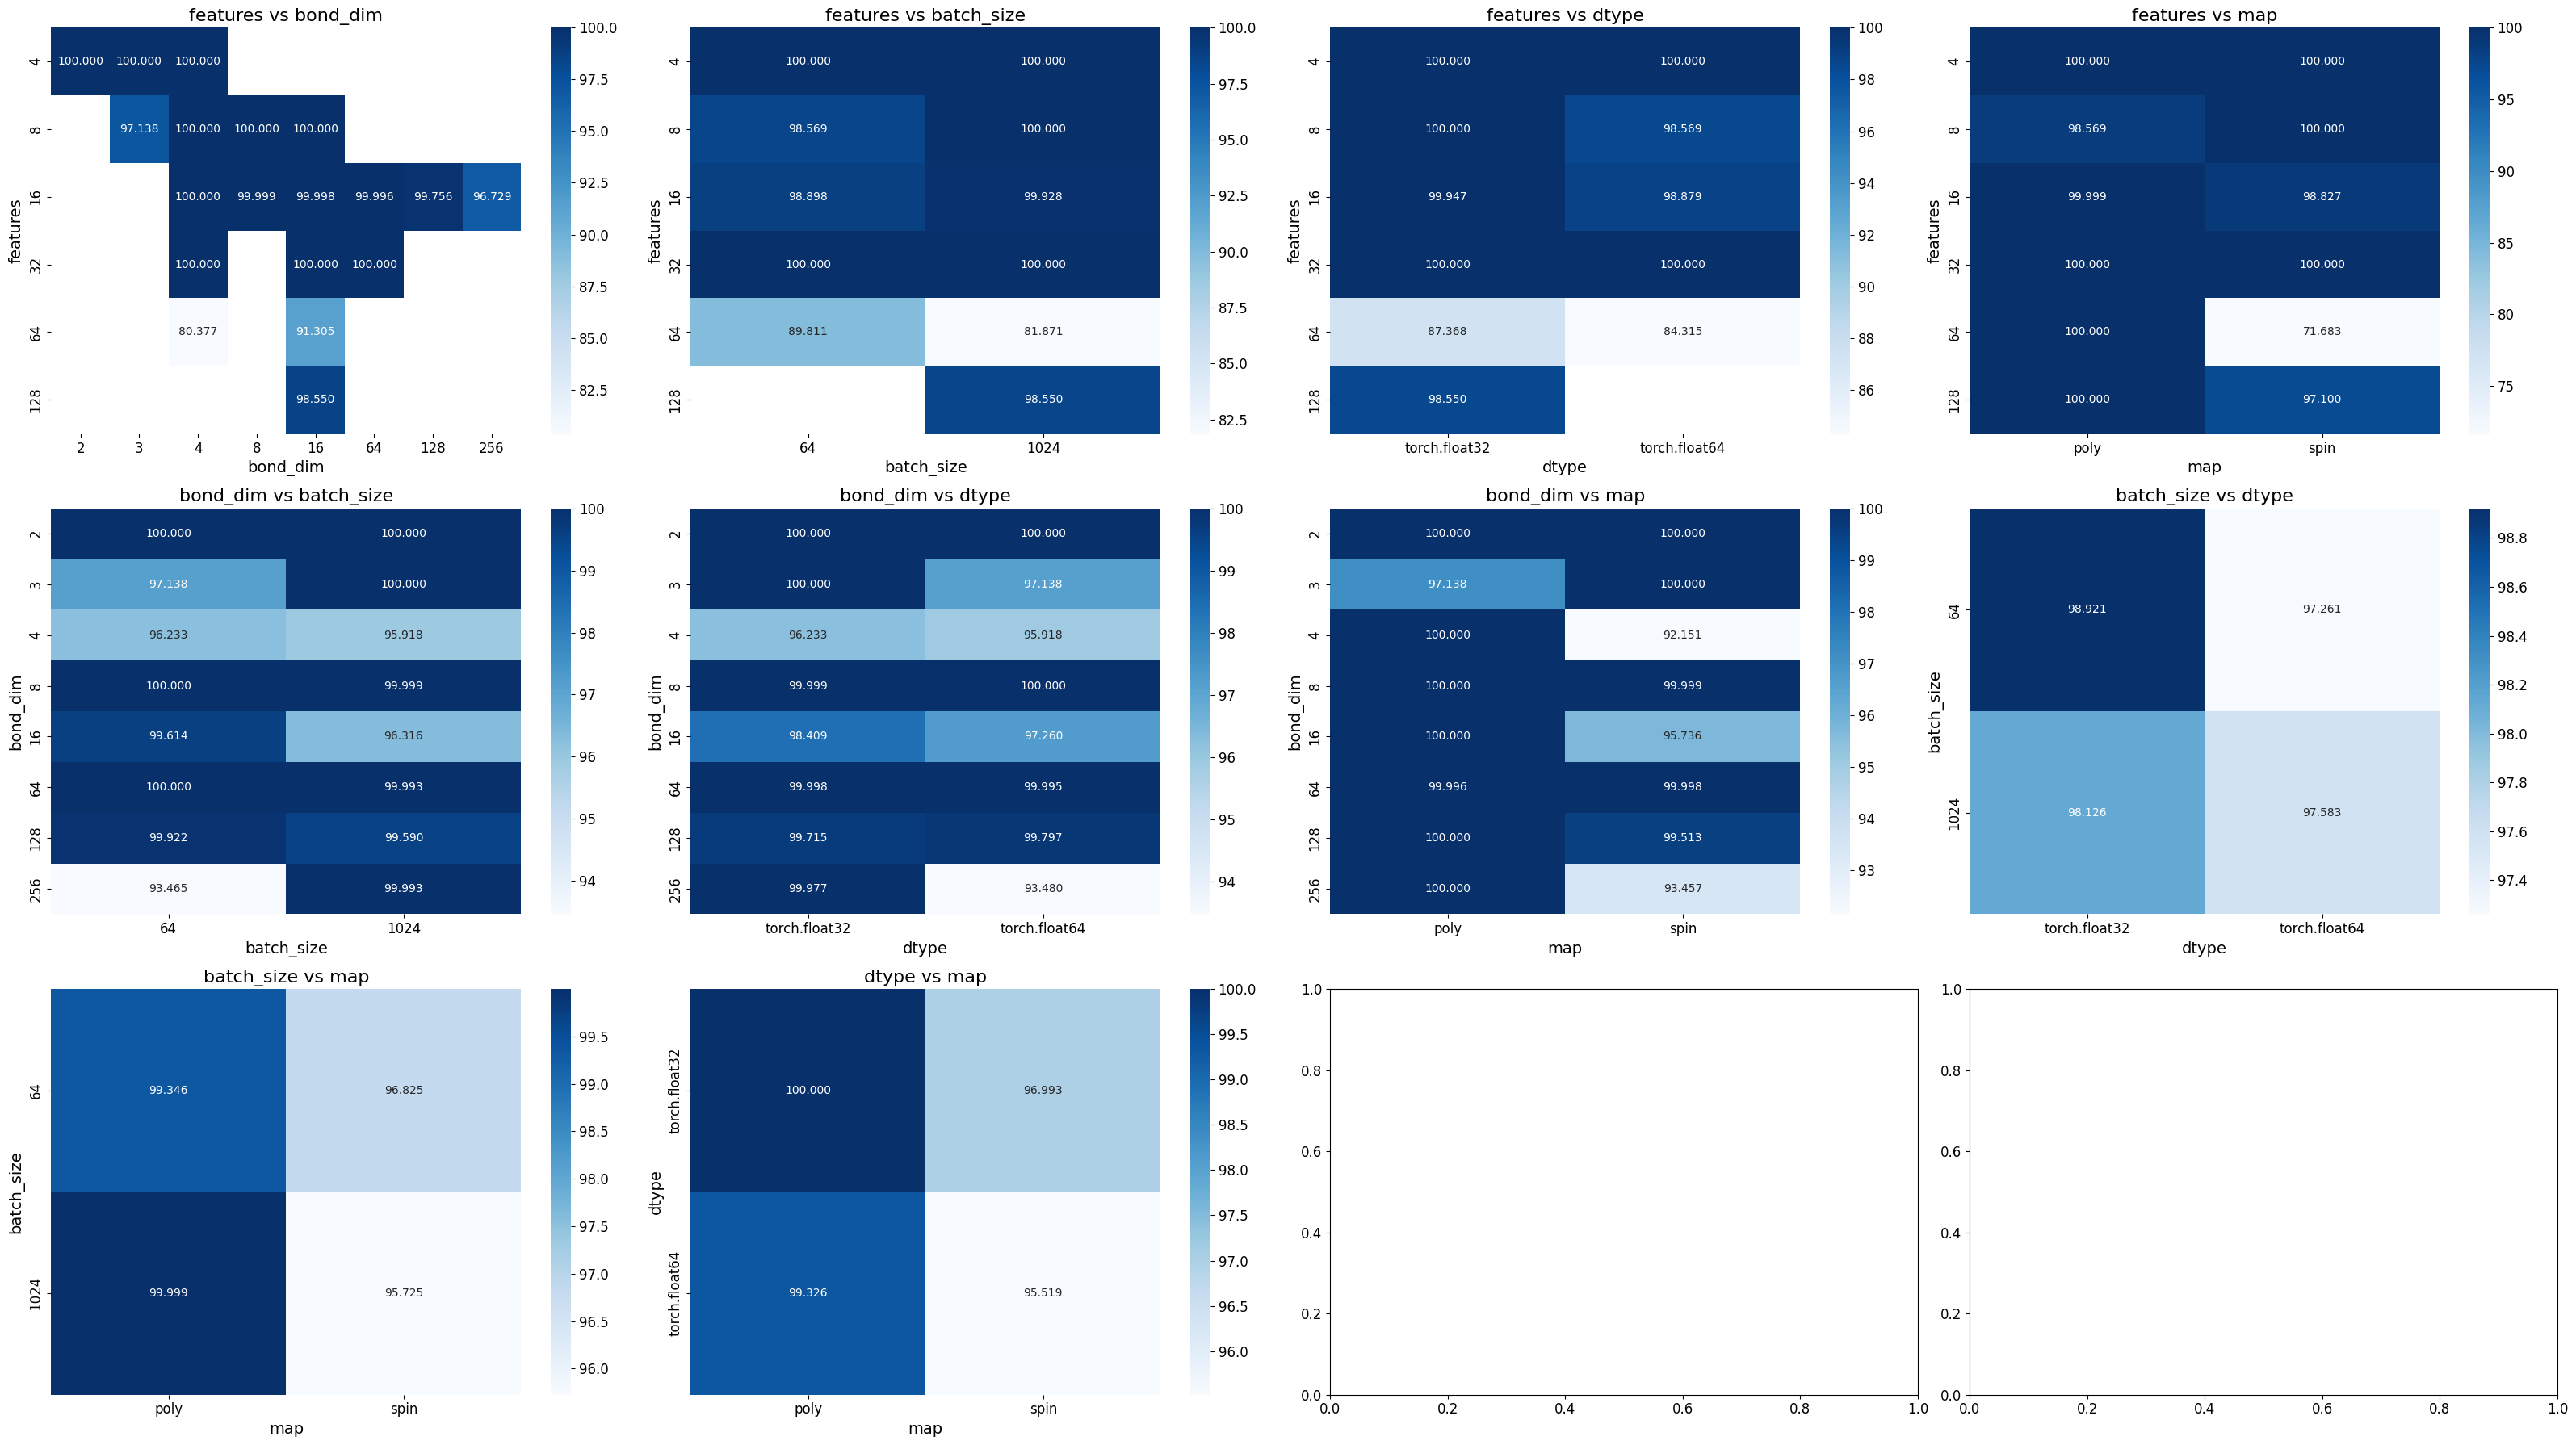

In [166]:
fix = {'sweep': True, 'initialize': True}
fig, ax = heat_pairplot(data_df, list(df_initTrue.columns[:7]), fix = fix)
for a in ax:
    a.tick_params(labelsize=FONTSIZE-2)
    a.set_title(a.get_title(), fontsize=FONTSIZE+2)
    a.set_xlabel(a.get_xlabel(), fontsize=FONTSIZE)
    a.set_ylabel(a.get_ylabel(), fontsize=FONTSIZE)

fig.tight_layout()

fig.savefig(datadir + 'heatmaps_' + '_'.join([str(k)+str(v) for k, v in fix.items()]) + '.pdf')

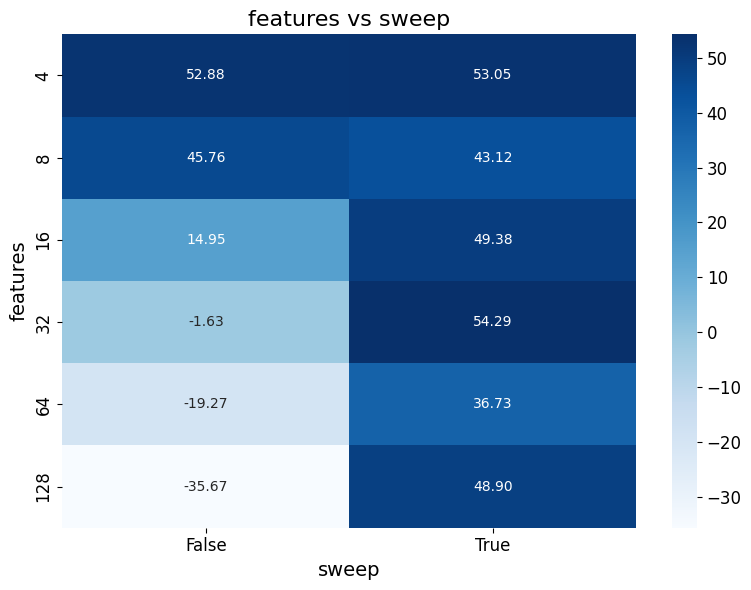

In [176]:
fix = {'initialize': True}
fig, ax = heat_pairplot(data_df, ['features', 'sweep'], value='test_acc_diff', fix=fix, fmt='.2f')

fig.tight_layout()
fig.savefig(datadir + 'feat_vs_sweep_accdiff_' + '_'.join([str(k)+str(v) for k, v in fix.items()]) + '.pdf')

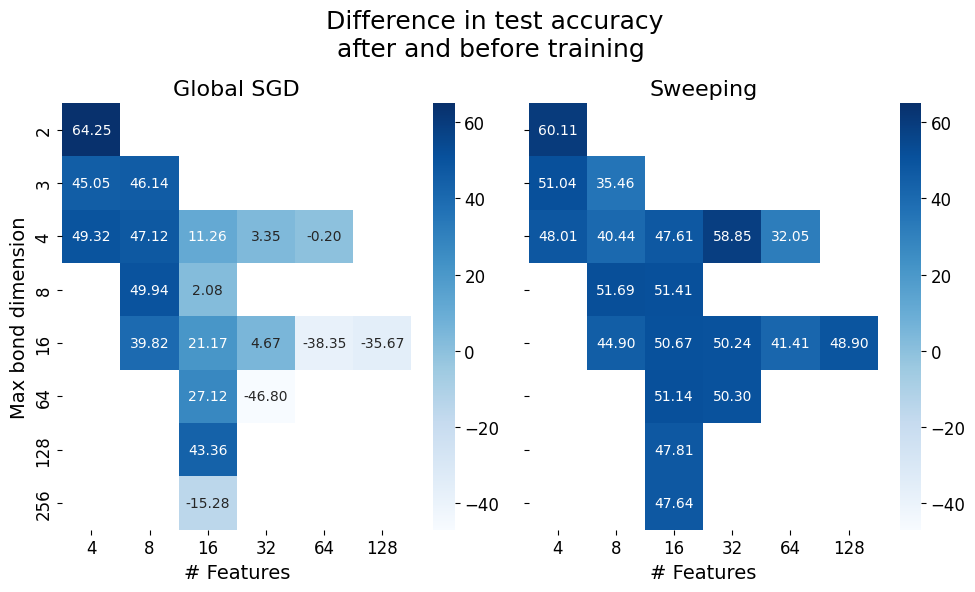

In [200]:
fix2 = {'initialize': True, 'sweep': False}
fix3 = {'initialize': True, 'sweep': True}
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True, sharex=True)

fig2, ax2 = heat_pairplot(data_df, ['bond_dim', 'features'], value='test_acc_diff', fix=fix2, fmt='.2f', ax=axes[0], cmap='Blues', vmin=-47, vmax=65)
fig3, ax3 = heat_pairplot(data_df, ['bond_dim', 'features'], value='test_acc_diff', fix=fix3, fmt='.2f', ax=axes[1], cmap='Blues', vmin=-47, vmax=65)
axes[0].set_title('Global SGD', fontsize=FONTSIZE+2)
axes[1].set_title('Sweeping', fontsize=FONTSIZE+2)
axes[0].set_ylabel('Max bond dimension', fontsize=FONTSIZE)
axes[0].set_xlabel('# Features', fontsize=FONTSIZE)
axes[1].set_xlabel('# Features', fontsize=FONTSIZE)
axes[0].tick_params(labelsize=FONTSIZE-2)
axes[1].tick_params(labelsize=FONTSIZE-2)
axes[1].set_ylabel('')
fig.suptitle('Difference in test accuracy\nafter and before training ', fontsize=FONTSIZE+4)
fig.tight_layout()
fig.savefig(datadir + 'bond_vs_feat_accdiff_bySweep' + '.pdf')

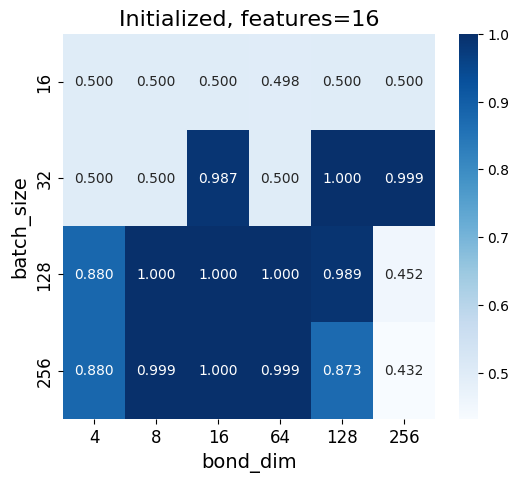

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

sns.heatmap(df_initTrue[(df_initTrue['features']==16) & (df_initTrue['dtype']=='torch.complex128')].pivot_table(index='batch_size', columns='bond_dim', values='test_acc', aggfunc='mean'), annot=True, fmt='.3f', cmap='Blues', ax=ax)
ax.set_title('Initialized, features=16', fontsize=FONTSIZE+2)
ax.set_xlabel('bond_dim', fontsize=FONTSIZE)
ax.set_ylabel('batch_size', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)

fig.savefig(datadir + 'heatmap_initTrue_features16.png', dpi=600)

## Dynamic range

In [3]:
root_dir = 'data/grid_search2/'
file_list = glob('model_*True_ttorch.float64*.pth', root_dir=root_dir)
print(len(file_list))

155


In [4]:
import re

feat_bd_tofile_dict = {}
for file in file_list:
    feat = int(re.findall(r'\d+', file.split('_')[1])[0])
    bd = int(re.findall(r'\d+', file.split('_')[2])[0])
    if feat not in feat_bd_tofile_dict:
        feat_bd_tofile_dict[feat] = {}
    feat_bd_tofile_dict[feat][bd] = [file] + feat_bd_tofile_dict[feat].get(bd, [])

In [5]:
features = list(feat_bd_tofile_dict.keys())
features.sort()
bds = []
for feat in features:
    bds += list(feat_bd_tofile_dict[feat].keys())
bds = np.unique(bds).tolist()

df = pd.DataFrame(index=pd.MultiIndex.from_product([features, bds], names=['feat', 'bd']), columns=['abs_min', 'abs_max', 'mean_min', 'mean_max', 'std_min', 'std_max', 'n'], dtype=float)

for feat in features:
    for bd in bds:
        if bd in feat_bd_tofile_dict[feat]:
            abs_tensors = np.stack([np.concatenate([np.abs(x.cpu().numpy().flatten()) for x in torch.load(root_dir + file).values()]) for file in feat_bd_tofile_dict[feat][bd]], axis=0)
            df.loc[feat, bd] = [np.min(abs_tensors), np.max(abs_tensors), np.mean(abs_tensors.min(-1)), np.mean(abs_tensors.max(-1)), 
                                np.std(abs_tensors.min(-1)), np.std(abs_tensors.max(-1)), abs_tensors.shape[0]]
        else:
            df.loc[feat, bd] = [None, None, None, None, None, None, 0]


In [6]:
df

abs_min   abs_max      mean_min  mean_max       std_min  \
feat bd                                                                   
4    2     3.987884e-35  1.275735  6.669258e-04  1.132071  1.357063e-03   
     3     4.638111e-16  1.273866  3.574235e-04  0.934746  7.479671e-04   
     4     3.652659e-31  1.271660  1.449368e-06  0.899319  4.312604e-06   
     8              NaN       NaN           NaN       NaN           NaN   
     16             NaN       NaN           NaN       NaN           NaN   
     64             NaN       NaN           NaN       NaN           NaN   
     128            NaN       NaN           NaN       NaN           NaN   
     256            NaN       NaN           NaN       NaN           NaN   
8    2              NaN       NaN           NaN       NaN           NaN   
     3     6.038781e-68  1.034742  8.304597e-06  0.956083  2.407715e-05   
     4    5.873681e-124  1.225649  7.325890e-20  0.934680  1.939860e-19   
     8    2.015862e-127  1.028487  1.939673e-26  0.917497  5.268297e-26   
     16   6.569301e-142  1.224678  8.286863e-18  0.928142  1.837444e-17   
     64             NaN       NaN           NaN       NaN           NaN   
     128            NaN       NaN           NaN       NaN           NaN   
     256            NaN       NaN           NaN       NaN           NaN   
16   2              NaN       NaN           NaN       NaN           NaN   
     3              NaN       NaN           NaN       NaN           NaN   
     4     4.704543e-36  0.650322  4.656139e-05  0.587422  7.501533e-05   
     8    3.956471e-138  1.043296  8.392619e-29  0.775228  2.517631e-28   
     16   5.171909e-134  1.065653  6.828883e-06  0.622468  1.287357e-05   
     64   1.778541e-144  1.090207  4.972729e-07  0.667055  6.959423e-07   
     128  2.329645e-176  2.805981  3.589992e-07  1.249534  1.004856e-06   
     256  1.222949e-141  5.478232  8.763151e-08  1.388667  1.957903e-07   
32   2              NaN       NaN           NaN       NaN           NaN   
     3              NaN       NaN           NaN       NaN           NaN   
     4     2.640966e-62  0.569242  9.062335e-06  0.502338  8.910478e-06   
     8              NaN       NaN           NaN       NaN           NaN   
     16    8.929658e-12  0.378196  6.462892e-07  0.329598  8.208659e-07   
     64    1.226993e-13  0.282358  9.539147e-09  0.242659  1.378586e-08   
     128            NaN       NaN           NaN       NaN           NaN   
     256            NaN       NaN           NaN       NaN           NaN   

           std_max     n  
feat bd                   
4    2    0.150636  10.0  
     3    0.230197  10.0  
     4    0.261367  10.0  
     8         NaN   0.0  
     16        NaN   0.0  
     64        NaN   0.0  
     128       NaN   0.0  
     256       NaN   0.0  
8    2         NaN   0.0  
     3    0.077914  10.0  
     4    0.141272  10.0  
     8    0.110754  10.0  
     16   0.189726  10.0  
     64        NaN   0.0  
     128       NaN   0.0  
     256       NaN   0.0  
16   2         NaN   0.0  
     3         NaN   0.0  
     4    0.039952  10.0  
     8    0.212776  10.0  
     16   0.351578  10.0  
     64   0.419146  10.0  
     128  0.744551  10.0  
     256  1.502309  10.0  
32   2         NaN   0.0  
     3         NaN   0.0  
     4    0.039141  10.0  
     8         NaN   0.0  
     16   0.059179  10.0  
     64   0.027530   5.0  
     128       NaN   0.0  
     256       NaN   0.0

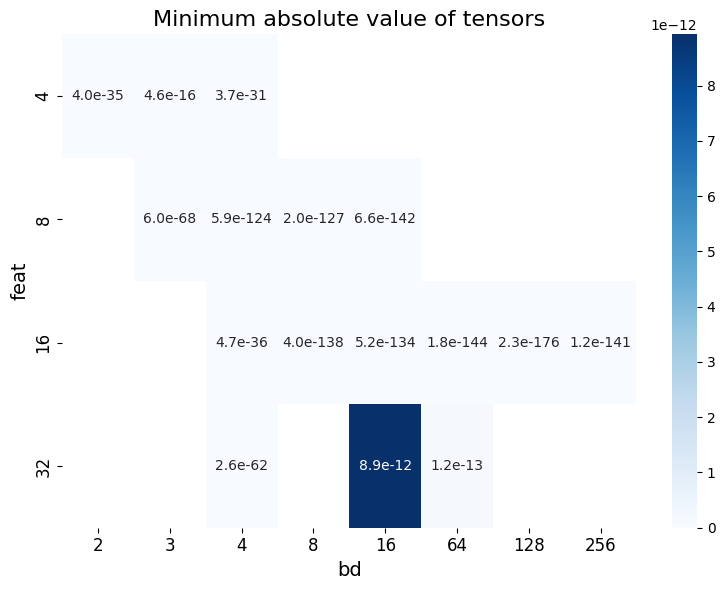

In [9]:
fig, ax = heat_pairplot(df, ['feat', 'bd'], 'abs_min', fmt='2.1e')
ax[0].set_title('Minimum absolute value of tensors', fontsize=FONTSIZE+2)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=FONTSIZE)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()
fig.savefig(root_dir + 'heatmap_abs_min.png', dpi=600)

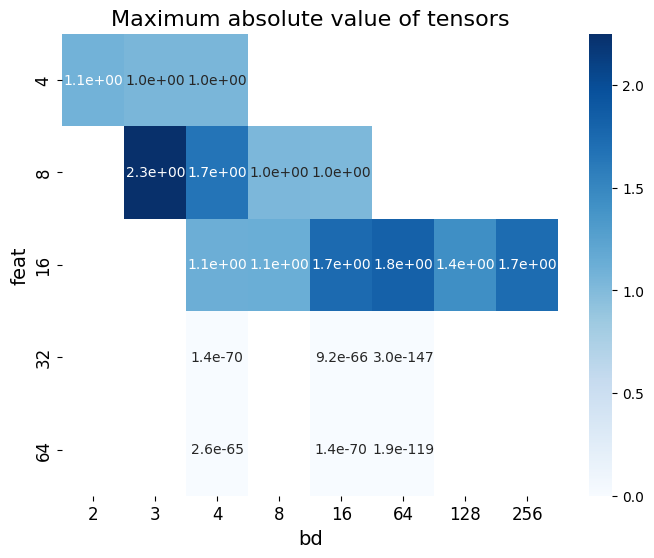

In [58]:
fog, ax = heat_pairplot(df, ['feat', 'bd'], 'abs_max', fmt='2.1e')
ax[0].set_title('Maximum absolute value of tensors', fontsize=FONTSIZE+2)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=FONTSIZE)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()
fig.savefig('data/grid_search/heatmap_abs_max.png', dpi=600)

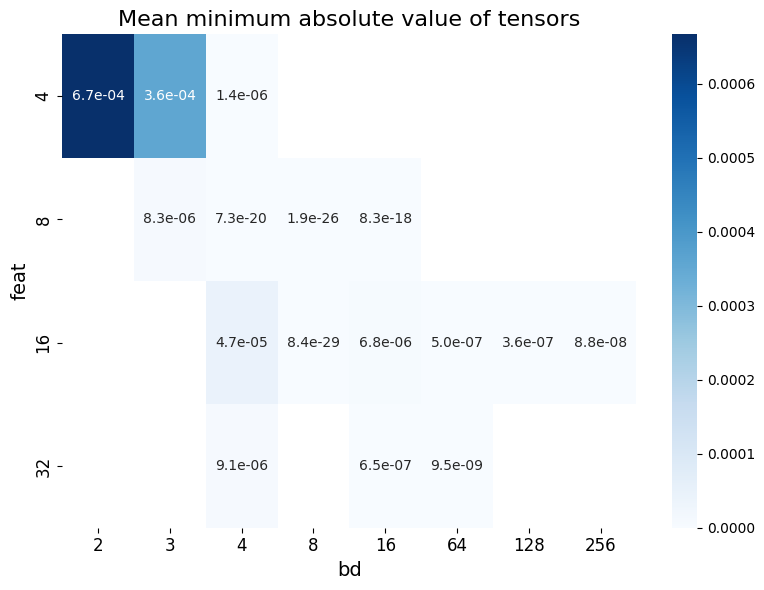

In [10]:
fig, ax = heat_pairplot(df, ['feat', 'bd'], 'mean_min', fmt='2.1e')
ax[0].set_title('Mean minimum absolute value of tensors', fontsize=FONTSIZE+2)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=FONTSIZE)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()
fig.savefig('data/grid_search/heatmap_mean_min.png', dpi=600)

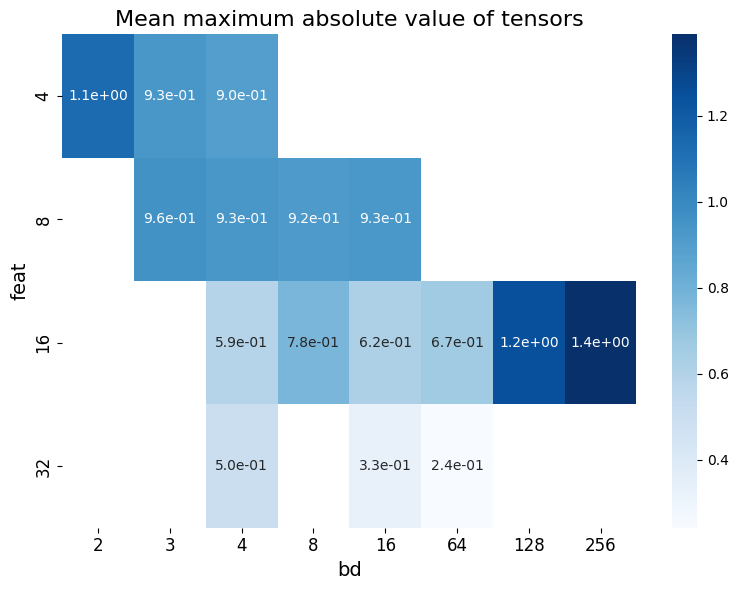

In [11]:
fig, ax = heat_pairplot(df, ['feat', 'bd'], 'mean_max', fmt='2.1e')
ax[0].set_title('Mean maximum absolute value of tensors', fontsize=FONTSIZE+2)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=FONTSIZE)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=FONTSIZE)
ax[0].tick_params(labelsize=FONTSIZE-2)
fig.tight_layout()
fig.savefig(root_dir + 'heatmap_mean_max.png', dpi=600)

# Fixed precision analysis

In [17]:
datadir = 'data/grid_search_fp2_striped/'
DATASET = datadir.split('_')[-1][:-1]
df = pd.read_csv(datadir + 'grid_search.csv', index_col=0)
df = df.fillna(0)
df

,bond_dim,quantize,wl,il,sample,loss,train_acc,test_acc,train_acc0,test_acc0,auc,time
0,3,True,4.0,1.0,0,0.269572,0.5000,0.500,0.5000,0.500,0.500000,113.683911
1,3,True,4.0,1.0,1,0.268530,0.5000,0.500,0.5000,0.500,0.501000,121.450653
2,3,True,4.0,1.0,2,0.268983,0.5000,0.500,0.5000,0.500,0.500000,126.721748
3,3,True,4.0,1.0,3,0.269309,0.5000,0.500,0.5000,0.500,0.500000,115.664275
4,3,True,4.0,1.0,4,0.268782,0.5000,0.500,0.5000,0.500,0.500000,124.414449
...,...,...,...,...,...,...,...,...,...,...,...,...
455,8,False,0.0,0.0,5,0.126366,0.7504,0.762,0.6379,0.654,0.541620,95.807179
456,8,False,0.0,0.0,6,0.126684,0.7504,0.762,0.5296,0.539,0.549888,94.808261
457,8,False,0.0,0.0,7,0.124958,0.7504,0.762,0.6248,0.641,0.539852,95.749394
458,8,False,0.0,0.0,8,0.125656,0.7504,0.762,0.6272,0.620,0.540408,95.563395


In [3]:
df[(df['bond_dim'] == 3) & (df['wl'] == 6) & (df['il']==2)]

,bond_dim,quantize,wl,il,sample,loss,train_acc,test_acc,train_acc0,test_acc0,auc,time
70,3,True,6.0,2.0,0,0.101395,0.741176,0.747059,0.542647,0.552941,0.821592,66.216222
71,3,True,6.0,2.0,1,0.104516,0.713235,0.735294,0.500000,0.511765,0.848304,65.844954
72,3,True,6.0,2.0,2,0.100781,0.742647,0.735294,0.500000,0.500000,0.801522,65.613650
73,3,True,6.0,2.0,3,0.095603,0.770588,0.741176,0.466176,0.452941,0.795571,65.869648
74,3,True,6.0,2.0,4,0.100825,0.767647,0.752941,0.500000,0.500000,0.824360,66.415722
75,3,True,6.0,2.0,5,0.101151,0.732353,0.694118,0.622059,0.605882,0.758616,64.758002
76,3,True,6.0,2.0,6,0.093689,0.754412,0.735294,0.500000,0.500000,0.799308,65.198367
77,3,True,6.0,2.0,7,0.103684,0.741176,0.735294,0.591176,0.611765,0.806367,65.582411
78,3,True,6.0,2.0,8,0.099488,0.761765,0.729412,0.510294,0.505882,0.794879,64.633681
79,3,True,6.0,2.0,9,0.105065,0.732353,0.717647,0.511765,0.505882,0.780692,65.827828


In [3]:
#df = df[df['batch_size'] == 32]

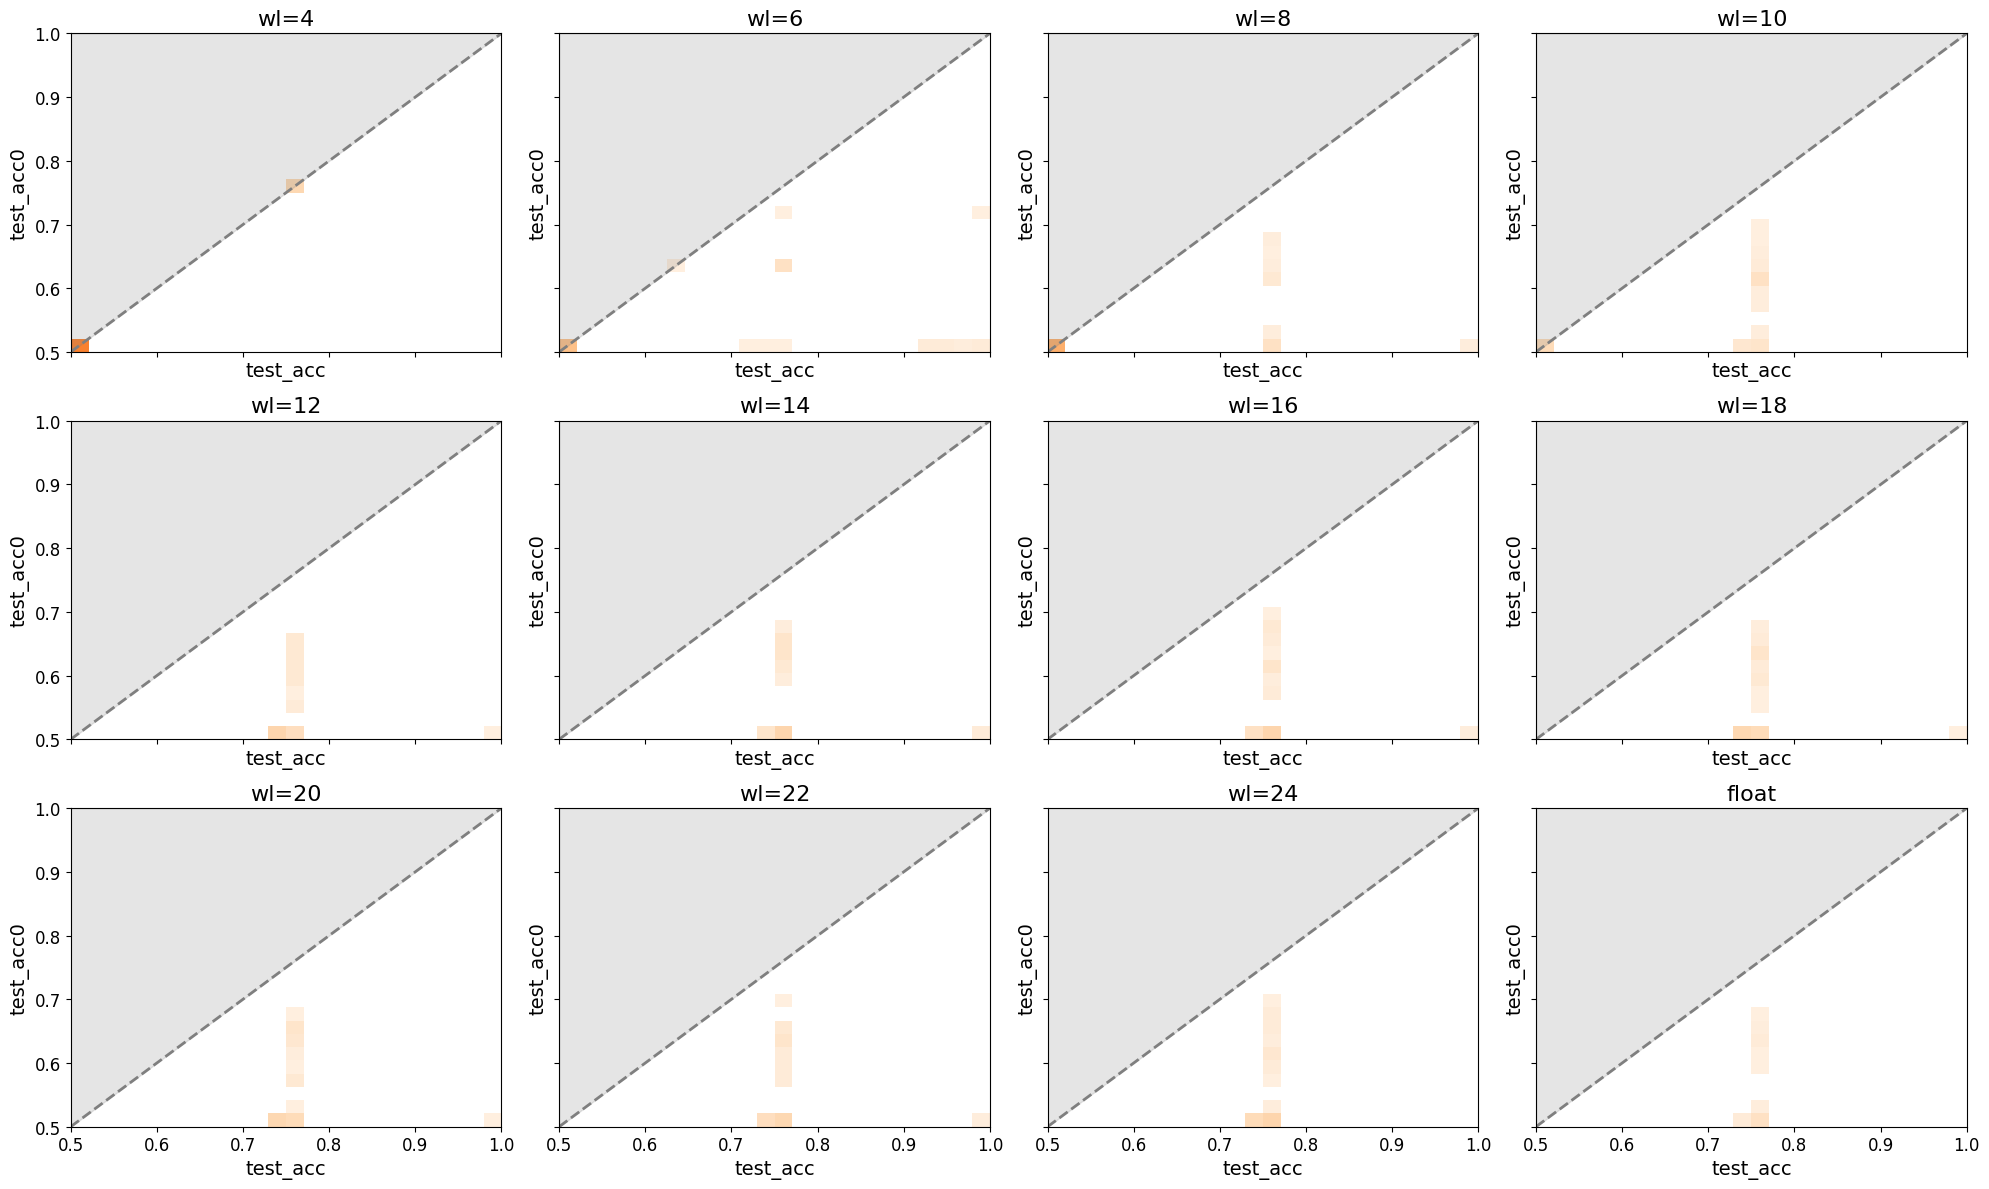

In [18]:
wls = df['wl'].unique()
w = math.ceil(len(wls)**0.5)
h = math.ceil(len(wls) / w)
fig, axs = plt.subplots(h, w, figsize=(5*w, 4*h), sharex=True, sharey=True)
axs = axs.flatten()
edges = np.linspace(0.5, 1.0, 25)

for i, wl in enumerate(wls):
    axs[i].hist2d(df[df['wl'] == wl]['test_acc'], df[df['wl'] == wl]['test_acc0'], cmap='Oranges', bins=edges, cmin=0.1, vmin=-2, vmax=len(df)//8)
    axs[i].plot([0.5, 1.0], [0.5, 1.0], color='tab:grey', linestyle='--', lw=2)
    axs[i].fill_between([0.5, 1.0], [0.5, 1.0], 1, color='tab:grey', alpha=0.2)
    axs[i].set_title(f'wl={int(wl)}' if wl > 0 else 'float', fontsize=FONTSIZE+2)
    axs[i].set_xlabel('test_acc', fontsize=FONTSIZE)
    axs[i].set_ylabel('test_acc0', fontsize=FONTSIZE)
    axs[i].tick_params(labelsize=FONTSIZE-2)


fig.tight_layout()
fig.savefig(datadir + DATASET + '_heatmaps.pdf')

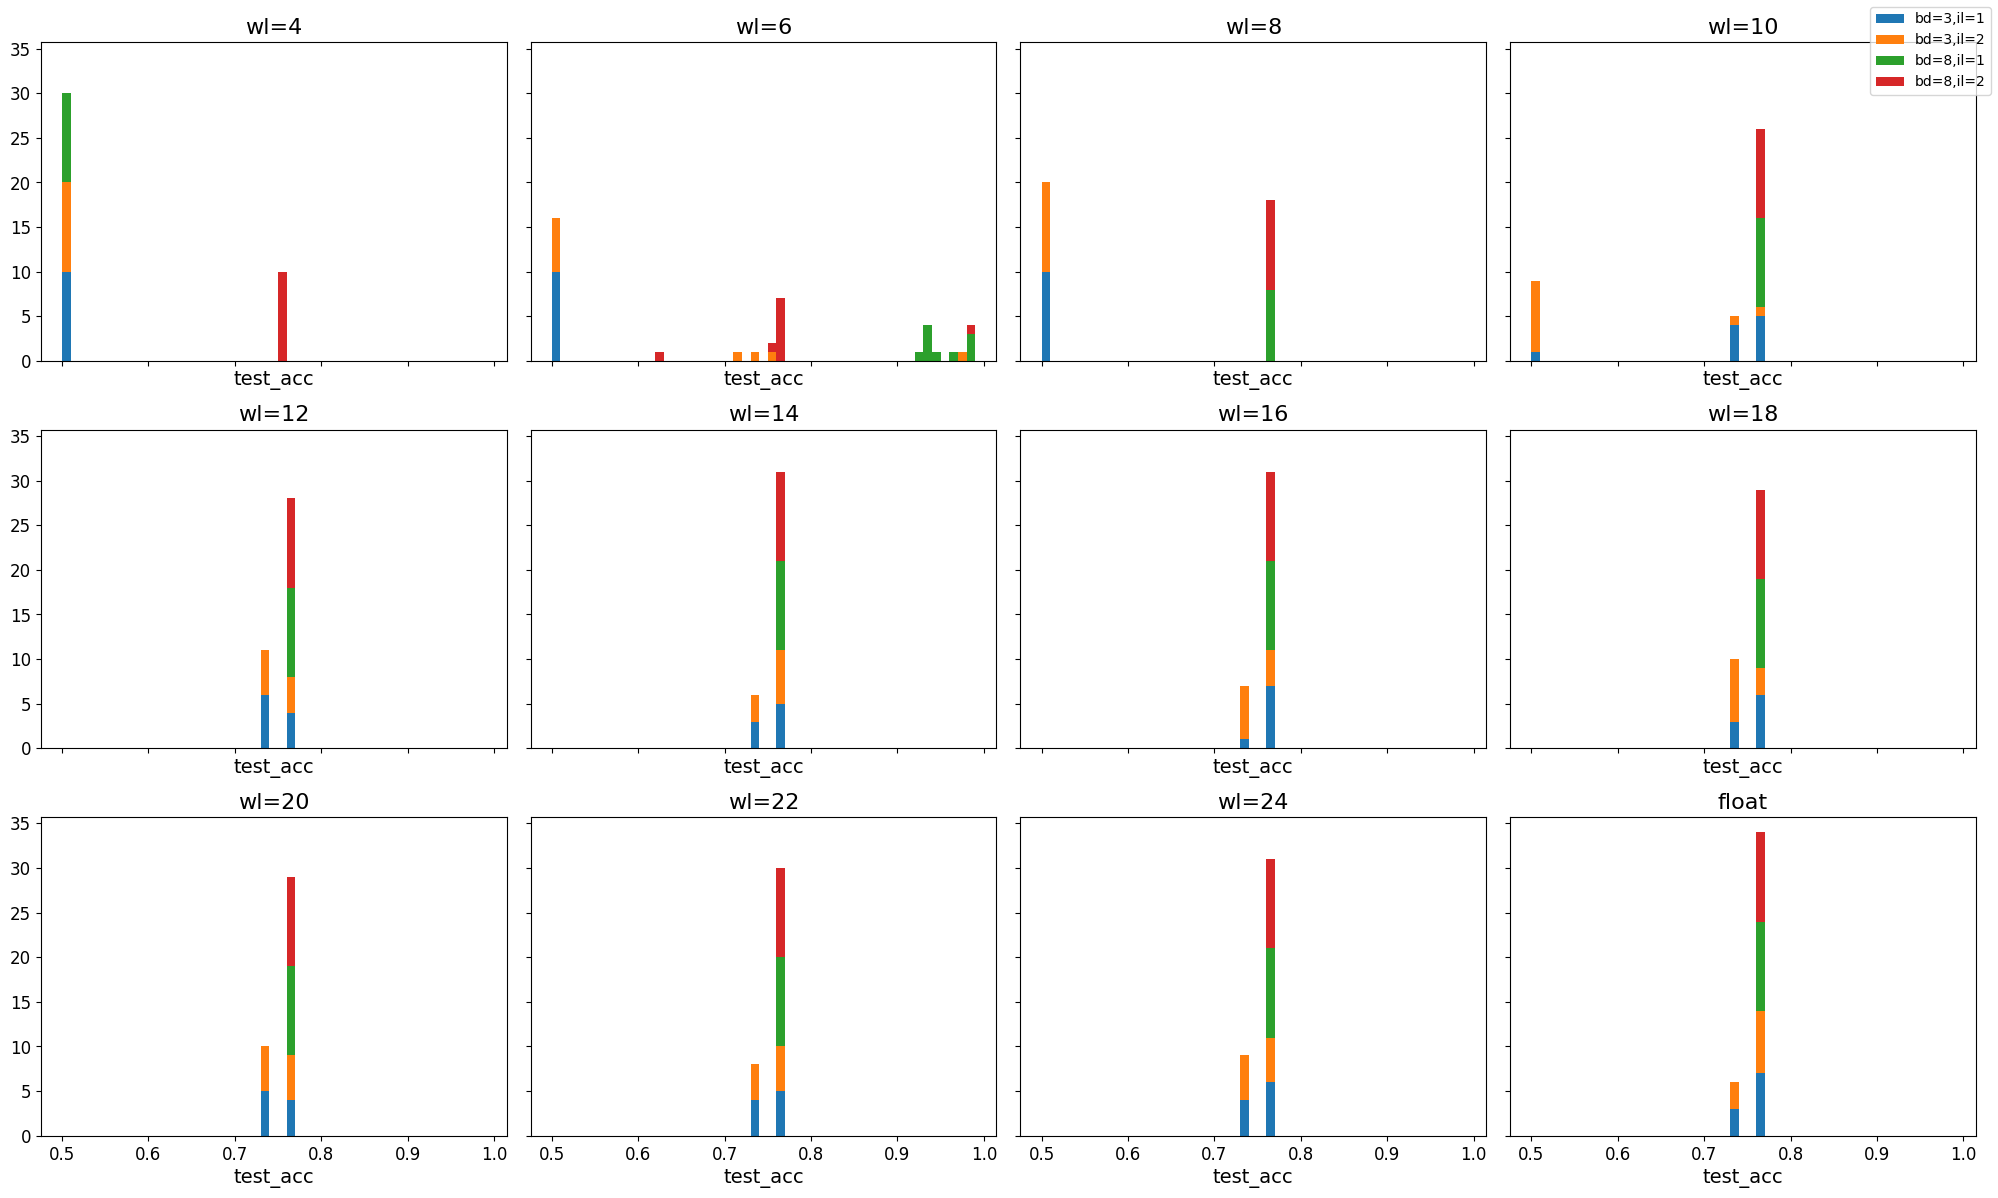

In [19]:
fig, axs = plt.subplots(h, w, figsize=(5*w, 4*h), sharex=True, sharey=True)
axs = axs.flatten()
bins = np.linspace(0.5, 0.99, 50)

bds = df['bond_dim'].unique()

df_bd3 = df[df['bond_dim'] == 3]
df_bd8 = df[df['bond_dim'] == 8]

for i, wl in enumerate(wls):
    axs[i].hist([df[(df['bond_dim'] == bd) & (df['wl'] == wl) & ((df['il'] == il) | (df['il'] == 0))]['test_acc'] for bd in bds for il in [1, 2]], 
                 bins=bins, label=[f'bd={bd},il={il}' for bd in bds for il in [1, 2]], stacked=True)
    axs[i].set_title(f'wl={int(wl)}' if wl > 0 else 'float', fontsize=FONTSIZE+2)
    axs[i].set_xlabel('test_acc', fontsize=FONTSIZE)
    axs[i].tick_params(labelsize=FONTSIZE-2)


fig.legend([f'bd={bd},il={il}' for bd in bds for il in [1, 2]])
fig.tight_layout()
fig.savefig(datadir + DATASET + '_hists.pdf')

In [11]:
df[df['test_acc'] > 0.9]

,bond_dim,quantize,wl,il,sample,loss,train_acc,test_acc,train_acc0,test_acc0,auc,time


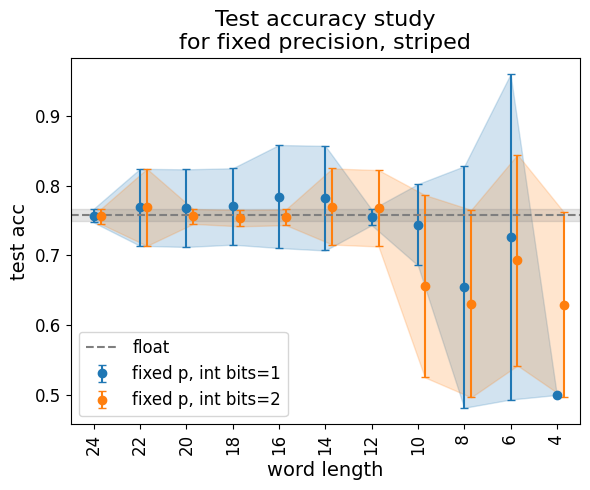

In [20]:
m_acc_f, std_acc_f = df[df['quantize'] == False]['test_acc'].mean(), df[df['quantize'] == False]['test_acc'].std()

wls = np.sort(df['wl'].unique())[::-1][:-1] # remove 0 i.e. float
ils = np.sort(df['il'].unique())[1:]        # remove 0 i.e. float

m_acc_q, std_acc_q = zip(*[(df[(df['wl'] == wl) & (df['il'] == il)]['test_acc'].mean(), 
                            df[(df['wl'] == wl) & (df['il'] == il)]['test_acc'].std()) 
                           for wl in wls for il in ils])
m_acc_q, std_acc_q = np.array(m_acc_q), np.array(std_acc_q)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

trans = matplotlib.transforms.offset_copy(ax.transData, fig=fig, x=5, y=0, units='points')
ax.errorbar(range(len(wls)), m_acc_q[::2], yerr=std_acc_q[::2], fmt='o', capthick=1, capsize=3, label='fixed p, int bits=1')
ax.errorbar(range(len(wls)), m_acc_q[1::2], yerr=std_acc_q[1::2], fmt='o', capthick=1, capsize=3, label='fixed p, int bits=2', transform=trans)
ax.fill_between(range(len(wls)), m_acc_q[::2]-std_acc_q[::2], m_acc_q[::2]+std_acc_q[::2], color='tab:blue', alpha=0.2)
ax.fill_between(range(len(wls)), m_acc_q[1::2]-std_acc_q[1::2], m_acc_q[1::2]+std_acc_q[1::2], color='tab:orange', alpha=0.2, transform=trans)
ax.axhline(m_acc_f, color='tab:grey', linestyle='--', label='float')
ax.axhspan(m_acc_f-std_acc_f, m_acc_f+std_acc_f, color='tab:grey', alpha=0.2)
ax.set_xticks(range(len(wls)))
ax.set_xticklabels([f'{wl:2.0f}' for wl in wls], rotation=90, fontsize=FONTSIZE-2)
ax.set_title(f'Test accuracy study\nfor fixed precision, {DATASET}', fontsize=FONTSIZE+2)
ax.set_xlabel('word length', fontsize=FONTSIZE)
ax.set_ylabel('test acc', fontsize=FONTSIZE)
ax.tick_params(labelsize=FONTSIZE-2)
ax.legend(fontsize=FONTSIZE-2, loc='lower left')
fig.tight_layout()
fig.savefig(datadir + DATASET + '_acc_study.pdf')

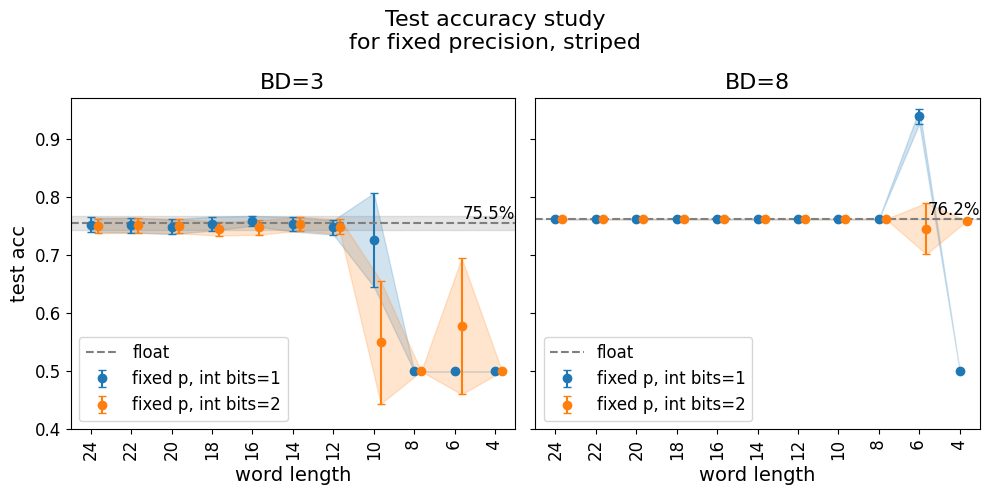

In [21]:
fig, axs = plt.subplots(1, len(bds), figsize=(5*len(bds), 5), sharex=True, sharey=True)
wls = np.sort(df['wl'].unique())[::-1][:-1] # remove 0 i.e. float
ils = np.sort(df['il'].unique())[1:]        # remove 0 i.e. float

ns=[]
cut = 0.971

for bd, ax in zip(bds, axs):
    df_bd = df[(df['bond_dim'] == bd) & (df['test_acc'] < cut)]

    m_acc_f, std_acc_f = df_bd[df_bd['quantize'] == False]['test_acc'].mean(), df_bd[df_bd['quantize'] == False]['test_acc'].std()

    m_acc_q, std_acc_q, n = zip(*[(df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il)]['test_acc'].mean(), 
                                df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il)]['test_acc'].std(),
                                df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il)]['test_acc'].count())
                            for wl in wls for il in ils])
    ns.append(n)
    m_acc_q, std_acc_q = np.array(m_acc_q), np.array(std_acc_q)

    

    trans = matplotlib.transforms.offset_copy(ax.transData, fig=fig, x=5, y=0, units='points')
    ax.errorbar(range(len(wls)), m_acc_q[::2], yerr=std_acc_q[::2], fmt='o', capthick=1, capsize=3, label='fixed p, int bits=1')
    ax.errorbar(range(len(wls)), m_acc_q[1::2], yerr=std_acc_q[1::2], fmt='o', capthick=1, capsize=3, label='fixed p, int bits=2', transform=trans)
    ax.fill_between(range(len(wls)), m_acc_q[::2]-std_acc_q[::2], m_acc_q[::2]+std_acc_q[::2], color='tab:blue', alpha=0.2)
    ax.fill_between(range(len(wls)), m_acc_q[1::2]-std_acc_q[1::2], m_acc_q[1::2]+std_acc_q[1::2], color='tab:orange', alpha=0.2, transform=trans)
    ax.axhline(m_acc_f, color='tab:grey', linestyle='--', label='float')
    ax.axhspan(m_acc_f-std_acc_f, m_acc_f+std_acc_f, color='tab:grey', alpha=0.2)
    ax.set_xticks(range(len(wls)))
    ax.set_xticklabels([f'{wl:2.0f}' for wl in wls], rotation=90, fontsize=FONTSIZE-2)
    ax.set_title(f'BD={bd}', fontsize=FONTSIZE+2)
    ax.set_xlabel('word length', fontsize=FONTSIZE)
    ax.set_ylim(0.4, cut)
    ax.set_xlim(-0.5, len(wls)-0.5)
    ax.text(1., (m_acc_f-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]), f'{m_acc_f:2.1%}', transform=ax.transAxes, fontsize=FONTSIZE-2, ha='right', va='bottom')
    ax.tick_params(labelsize=FONTSIZE-2)
    ax.legend(fontsize=FONTSIZE-2, loc='lower left')

axs[0].set_ylabel('test acc', fontsize=FONTSIZE)

fig.suptitle(f'Test accuracy study\nfor fixed precision, {DATASET}', fontsize=FONTSIZE+2)
fig.tight_layout()
fig.savefig(datadir + DATASET + f'_acc_study_bd_cut{cut}.pdf')

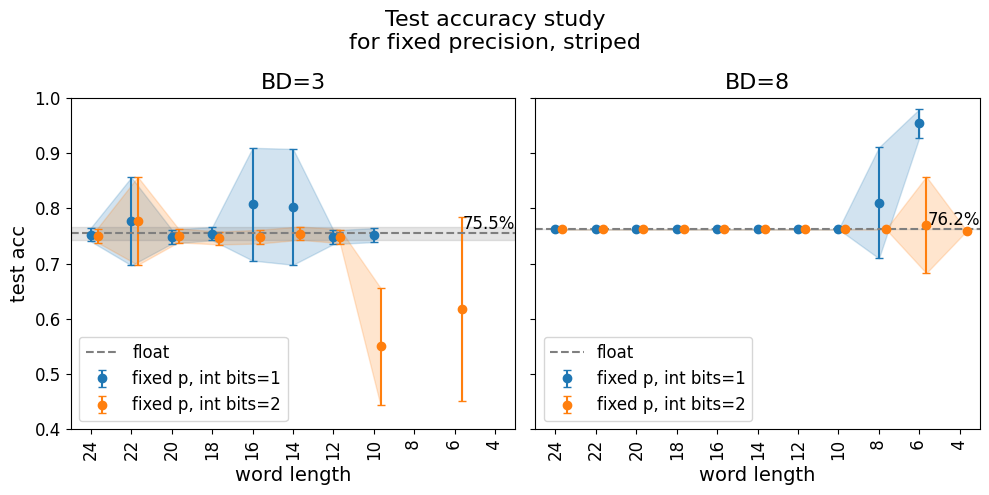

In [22]:
# cut based on std

fig, axs = plt.subplots(1, len(bds), figsize=(5*len(bds), 5), sharex=True, sharey=True)
wls = np.sort(df['wl'].unique())[::-1][:-1] # remove 0 i.e. float
ils = np.sort(df['il'].unique())[1:]        # remove 0 i.e. float

ns=[]
n_std = 3.

for bd, ax in zip(bds, axs):
    df_bd = df[df['bond_dim'] == bd]

    m_acc_f, std_acc_f = df_bd[df_bd['quantize'] == False]['test_acc'].mean(), df_bd[df_bd['quantize'] == False]['test_acc'].std()

    mode_acc_q, std0_acc_q, n = zip(*[(df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il)]['test_acc'].mode(), 
                                   df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il)]['test_acc'].std(),
                                   df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il)]['test_acc'].count())
                                  for wl in wls for il in ils])
    m_acc_q, std_acc_q, n = zip(*[(df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il) & ((df_bd['test_acc'] - mode_acc_q[i*len(ils)+j].iloc[-1]).abs() < n_std*std0_acc_q[i*len(ils)+j])]['test_acc'].mean(), 
                                   df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il) & ((df_bd['test_acc'] - mode_acc_q[i*len(ils)+j].iloc[-1]).abs() < n_std*std0_acc_q[i*len(ils)+j])]['test_acc'].std(),
                                   df_bd[(df_bd['wl'] == wl) & (df_bd['il'] == il) & ((df_bd['test_acc'] - mode_acc_q[i*len(ils)+j].iloc[-1]).abs() < n_std*std0_acc_q[i*len(ils)+j])]['test_acc'].count())
                                  for i, wl in enumerate(wls) for j, il in enumerate(ils)])
    ns.append(n)
    m_acc_q, std_acc_q = np.array(m_acc_q), np.array(std_acc_q)

    

    trans = matplotlib.transforms.offset_copy(ax.transData, fig=fig, x=5, y=0, units='points')
    ax.errorbar(range(len(wls)), m_acc_q[::2], yerr=std_acc_q[::2], fmt='o', capthick=1, capsize=3, label='fixed p, int bits=1')
    ax.errorbar(range(len(wls)), m_acc_q[1::2], yerr=std_acc_q[1::2], fmt='o', capthick=1, capsize=3, label='fixed p, int bits=2', transform=trans)
    ax.fill_between(range(len(wls)), m_acc_q[::2]-std_acc_q[::2], m_acc_q[::2]+std_acc_q[::2], color='tab:blue', alpha=0.2)
    ax.fill_between(range(len(wls)), m_acc_q[1::2]-std_acc_q[1::2], m_acc_q[1::2]+std_acc_q[1::2], color='tab:orange', alpha=0.2, transform=trans)
    ax.axhline(m_acc_f, color='tab:grey', linestyle='--', label='float')
    ax.axhspan(m_acc_f-std_acc_f, m_acc_f+std_acc_f, color='tab:grey', alpha=0.2)
    ax.set_xticks(range(len(wls)))
    ax.set_xticklabels([f'{wl:2.0f}' for wl in wls], rotation=90, fontsize=FONTSIZE-2)
    ax.set_title(f'BD={bd}', fontsize=FONTSIZE+2)
    ax.set_xlabel('word length', fontsize=FONTSIZE)
    
    ax.tick_params(labelsize=FONTSIZE-2)
    ax.set_ylim(0.4, 1.)
    ax.set_xlim(-0.5, len(wls)-0.5)
    ax.text(1., (m_acc_f-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]), f'{m_acc_f:2.1%}', transform=ax.transAxes, fontsize=FONTSIZE-2, ha='right', va='bottom')
    
    ax.legend(fontsize=FONTSIZE-2, loc='lower left')

axs[0].set_ylabel('test acc', fontsize=FONTSIZE)
fig.suptitle(f'Test accuracy study\nfor fixed precision, {DATASET}', fontsize=FONTSIZE+2)
fig.tight_layout()
fig.savefig(datadir + DATASET + f'_acc_study_bd_stdcut{n_std}.pdf')

In [93]:
std0_acc_q

(1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 1.1702778228589004e-16,
 0.10034961108267658,
 1.1702778228589004e-16,
 0.025734542285936735,
 0.08720786152125914,
 0.0,
 1.1702778228589004e-16)

In [79]:
(df_bd['test_acc'] - mode_acc_q[0].item()).abs()

230    0.262
231    0.262
232    0.262
233    0.262
234    0.262
       ...  
455    0.000
456    0.000
457    0.000
458    0.000
459    0.000
Name: test_acc, Length: 230, dtype: float64

# Weight distribution

In [29]:
data_dir = 'data/grid_search_fp3_titanic/'

wl = ''

weights_fnames = glob(data_dir + f'model_*_qTrue_wl{wl}*.pth')
weights_ls = [list(torch.load(fname).values()) for fname in weights_fnames]
weights = np.concatenate([np.concatenate([x.cpu().numpy().flatten() for x in w]) for w in weights_ls], axis=0)
print('percent over 1: {:.2%}'.format(np.sum(weights > 1)/weights.size))
print('percent over 1.2: {:.2%}'.format(np.sum(weights > 1.2)/weights.size))
abs_weights = np.abs(weights)
print('min: {:.2e}\nmax: {:.2e}\nmean: {:.2e}\nstd: {:.2e}'.format(np.min(abs_weights[abs_weights > 0]), np.max(weights), np.mean(weights), np.std(weights)))

percent over 1: 0.06%
percent over 1.2: 0.00%
min: 1.19e-07
max: 1.25e+00
mean: 1.77e-02
std: 1.57e-01


In [17]:
fname = glob('qmodels/trainedmodel_titanic_bd16_spin_*')[0]
weights = list(torch.load(fname)().values())
weights = np.concatenate([x.cpu().numpy().flatten() for x in weights])
print('percent over 1: {:.2%}'.format(np.sum(weights > 1)/weights.size))
print('percent over 1.2: {:.2%}'.format(np.sum(weights > 1.2)/weights.size))
abs_weights = np.abs(weights)
print('min: {:.2e}\nmax: {:.2e}\nmean: {:.2e}\nstd: {:.2e}'.format(np.min(abs_weights), np.max(weights), np.mean(weights), np.std(weights)))

percent over 1: 0.26%
percent over 1.2: 0.00%
min: 2.77e-05
max: 1.04e+00
mean: 2.27e-02
std: 1.67e-01


(array([1.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 9.000e+00, 1.200e+01, 1.400e+01, 1.000e+01, 1.100e+01,
        7.000e+00, 8.000e+00, 6.000e+00, 1.800e+01, 1.500e+01, 1.100e+01,
        2.000e+01, 2.000e+01, 6.000e+01, 4.255e+03, 1.180e+02, 3.100e+01,
        2.700e+01, 2.400e+01, 2.900e+01, 2.200e+01, 1.400e+01, 1.500e+01,
        6.000e+00, 9.000e+00, 7.000e+00, 1.000e+01, 6.000e+00, 6.000e+00,
        3.000e+00, 3.000e+00, 3.000e+00, 8.000e+00, 5.000e+00, 9.000e+00,
        5.000e+00, 8.000e+00, 8.000e+00, 6.000e+00, 4.000e+00, 1.300e+01,
        0.000e+00, 6.000e+01]),
 array([-0.79718286, -0.76063621, -0.72408962, -0.68754297, -0.65099639,
        -0.61444974, -0.57790315, -0.5413565 , -0.50480986, -0.46826327,
        -0.43171662, -0.39517   , -0.35862339, -0.32207677, -0.28553015,
        -0.24898352, -0.2124369 , -0.17589028, -0.13934365, -0.10279703,
        -0.06625041, -0.02970378,  0.00684284,  0.04338946,  0.07993608,
         0.

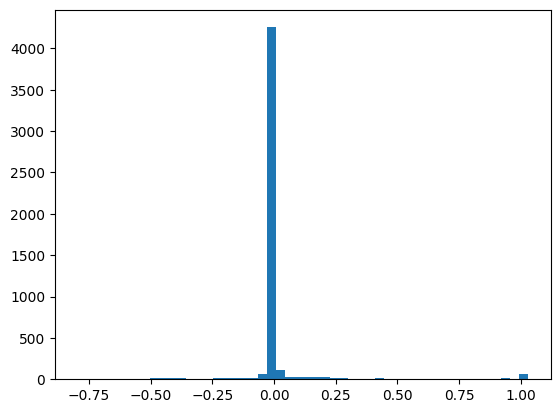

In [27]:
plt.hist(weights, bins=50)

# Entropy permutations

In [51]:
titanic_features[-1] = 'embark'

In [52]:
def draw_mi(mi, perm, fac_model, cmap='Reds'):

    cmap = colormaps.get_cmap('Reds')
    mi_min, mi_max = np.min(list(mi.values())), np.max(list(mi.values()))
    dot = graphviz.Digraph('Entropy', comment='TTN: ' + 'Entropy', engine='dot', format='svg', renderer='cairo', graph_attr={'bgcolour': 'transparent', 'rankdir': 'LR', 'splines':'false', 'size':'16,14', 'ratio':'compress', 'fontname':'Arial'})
    dot.attr('node', shape='circle', width='0.55', fixedsize='true', fontsize=str(11))
    dot.attr('edge', color='#bfbfbf', fontsize=str(11-2))
    dot.edge('0.0', 'hide', label=fac_model.label_tag)
    dot.node('hide', '', shape='plaintext')
    for i, tindex in enumerate(fac_model.indices):
        c_rgba = list(cmap((mi[tindex.indices[-1]]-mi_min)/(mi_max-mi_min)))
        
        dot.node(tindex.name, tindex.name, fillcolor=colors.rgb2hex(c_rgba), style='filled', color = colors.rgb2hex(c_rgba), penwidth='4')
        
        dot.edge(tindex[0], tindex.name, label=str(tindex[0])+f' [{fac_model.tensors[i].shape[0]}]', weight=str((int(tindex.name.split('.')[0])+1)**2))
        dot.edge(tindex[1], tindex.name, label=str(tindex[1])+f' [{fac_model.tensors[i].shape[1]}]', weight=str((int(tindex.name.split('.')[0])+1)**2))

    for i in range(fac_model.n_features):
        index = f'data.{i}'
        c_rgba = list(cmap((mi[index]-mi_min)/(mi_max-mi_min)))
        label = titanic_features[perm[i]]
        dot.node(index, label, fillcolor=colors.rgb2hex(c_rgba), style='filled', color = colors.rgb2hex(c_rgba), penwidth='4')

    return dot

In [92]:
data_dir = 'data/grid_search_entropy_titanic/'
files = glob('entropy*', root_dir=data_dir)
permutations = np.load(data_dir + 'permutations.npy')
plt.ioff()
for file in files:
    split = file.split('_')
    bd = int(split[1][2:])
    perm_id = int(split[2][4:])
    perm = permutations[perm_id]
    fac_model = TTN(8, 2, 1, bond_dim=bd)
    dot = draw_mi(np.load(data_dir + file), perm, fac_model)
    dot.render(data_dir + 'images/' + file[:-4], format='png', renderer='cairo')
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    im = ax.imshow(Image.open(data_dir + 'images/' + file[:-4] + '.cairo.png'))
    ax.axis('off')
    ax.set_title(f'BD={bd}, perm={perm_id}', fontsize=FONTSIZE+2)
    mi = np.load(data_dir + file)
    mi_min, mi_max = np.min(list(mi.values())), np.max(list(mi.values()))
    fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(mi_min, mi_max), cmap='Reds'), ax=ax, orientation='vertical')
    fig.tight_layout()
    fig.savefig(data_dir + 'images/' + file[:-4] + '.png', dpi=600)
    plt.close(fig)
    os.remove(data_dir + 'images/' + file[:-4] + '.cairo.png')


/tmp/ipykernel_1115877/3200060364.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))


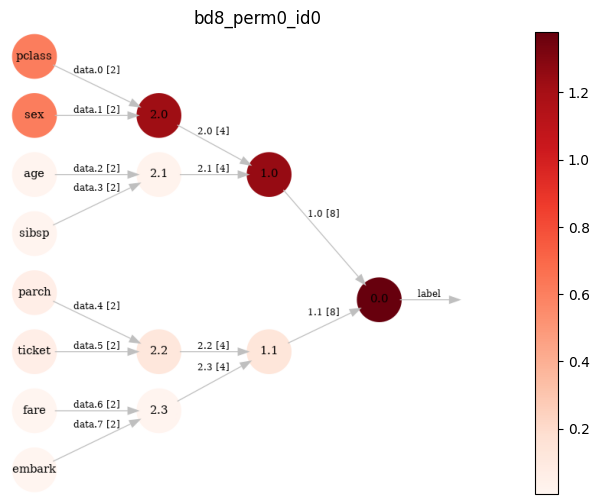

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.imshow(Image.open(data_dir + 'images/' + files[0][:-4] + '.cairo.png'))
ax.axis('off')
ax.set_title(files[0][8:-])
mi = np.load(data_dir + files[0])
mi_min, mi_max = np.min(list(mi.values())), np.max(list(mi.values()))
fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(mi_min, mi_max), cmap='Reds'), ax=ax, orientation='vertical')


# Permutations

In [2]:
df = pd.read_csv('data/grid_search_perm/grid_search.csv', index_col=0)
df

,permutation,sample,loss,train_acc,test_acc,train_acc0,test_acc0,auc,time
0,"[6, 1, 3, 0, 7, 2, 4, 5]",0,0.117660,0.6105,0.580,0.5401,0.539,0.656713,76.032220
1,"[6, 1, 3, 0, 7, 2, 4, 5]",1,0.117344,0.6221,0.560,0.5181,0.553,0.656741,75.699637
2,"[6, 1, 3, 0, 7, 2, 4, 5]",2,0.117203,0.6293,0.538,0.5206,0.539,0.655649,79.365778
3,"[6, 1, 3, 0, 7, 2, 4, 5]",3,0.117260,0.6228,0.560,0.5370,0.547,0.656721,80.548868
4,"[6, 1, 3, 0, 7, 2, 4, 5]",4,0.117518,0.6267,0.554,0.5456,0.544,0.657261,80.555181
...,...,...,...,...,...,...,...,...,...
95,"[1, 4, 2, 5, 0, 3, 6, 7]",0,0.117851,0.6321,0.511,0.5492,0.532,0.649363,82.505884
96,"[1, 4, 2, 5, 0, 3, 6, 7]",1,0.118227,0.6280,0.535,0.5543,0.553,0.649583,80.674456
97,"[1, 4, 2, 5, 0, 3, 6, 7]",2,0.117937,0.6297,0.509,0.5377,0.558,0.649395,81.640622
98,"[1, 4, 2, 5, 0, 3, 6, 7]",3,0.117662,0.6307,0.511,0.5444,0.529,0.649935,81.636140


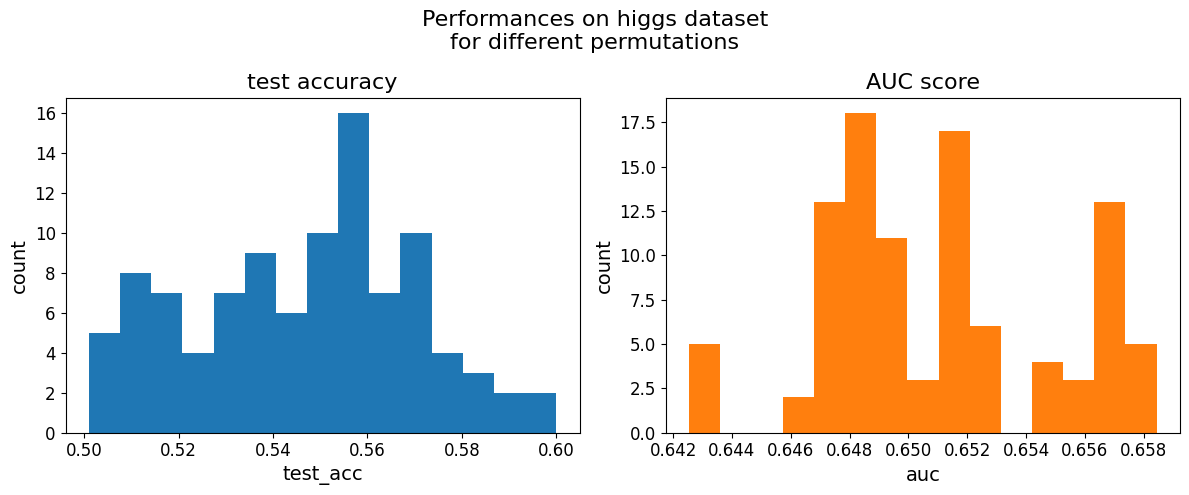

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

bins = 15

axs[0].hist(df['test_acc'], bins=bins, color='tab:blue')
axs[0].set_title('test accuracy', fontsize=FONTSIZE+2)
axs[0].set_xlabel('test_acc', fontsize=FONTSIZE)
axs[0].set_ylabel('count', fontsize=FONTSIZE)
axs[0].tick_params(labelsize=FONTSIZE-2)

axs[1].hist(df['auc'], bins=bins, color='tab:orange')
axs[1].set_title('AUC score', fontsize=FONTSIZE+2)
axs[1].set_xlabel('auc', fontsize=FONTSIZE)
axs[1].set_ylabel('count', fontsize=FONTSIZE)
axs[1].tick_params(labelsize=FONTSIZE-2)


fig.suptitle('Performances on higgs dataset\nfor different permutations', fontsize=FONTSIZE+2)
fig.tight_layout()
fig.savefig('data/grid_search_perm/higgs_perf.png', dpi=600)

# Gradient studies

In [2]:
grads = {}
'''
grads[4] = np.load('grad_study/grads_magnitude_2.npy')
grads[8] = np.load('grad_study/grads_magnitude_4_2.npy')
grads[16] = np.load('grad_study/grads_magnitude_4_4.npy')
grads[32] = np.load('grad_study/grads_magnitude_4_8.npy')
grads[64] = np.load('grad_study/grads_magnitude_8_8.npy')
grads[128] = np.load('grad_study/grads_magnitude_8_16.npy')
'''

grads[4] = np.load('grad_study/grads_magnitude_2x2.npy')
grads[8] = np.load('grad_study/grads_magnitude_4x2.npy')
grads[16] = np.load('grad_study/grads_magnitude_4x4.npy')
grads[32] = np.load('grad_study/grads_magnitude_4x8.npy')
grads[64] = np.load('grad_study/grads_magnitude_8x8.npy')
grads[128] = np.load('grad_study/grads_magnitude_8x16.npy')

as we are taking the absolute values of the gradient elements, we can take the median,
as the mean is not really meaningful being this an asymettric distribution

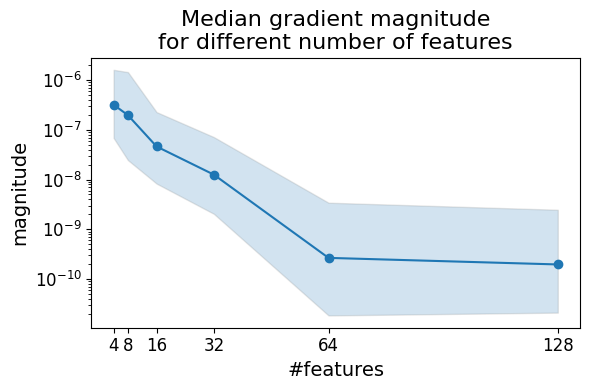

In [3]:

y = [np.median(np.abs(grad)) for grad in grads.values()]
x = [key for key in grads.keys()]
err = [np.std(np.abs(grad)) for grad in grads.values()]
x = np.array(x)
y = np.array(y)
err = np.array(err)
perc16 = [np.percentile(np.abs(grad), 16) for grad in grads.values()]
perc84 = [np.percentile(np.abs(grad), 84) for grad in grads.values()]

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(x, y, 'o-')
ax.fill_between(x, perc16, perc84, alpha=0.2, edgecolor='0.5')
#ax.set_xscale('log')

ax.set_yscale('log')
ax.set_xticks(x, x, fontsize=FONTSIZE-2)
ax.tick_params(axis='y', which='major', labelsize=FONTSIZE-2)
ax.set_xlabel('#features', fontsize=FONTSIZE)
ax.set_ylabel('magnitude', fontsize=FONTSIZE)
ax.set_title('Median gradient magnitude\nfor different number of features', fontsize=FONTSIZE+2)
fig.tight_layout()

In [4]:
fig.savefig('grad_study/grads_magnitude.pdf')

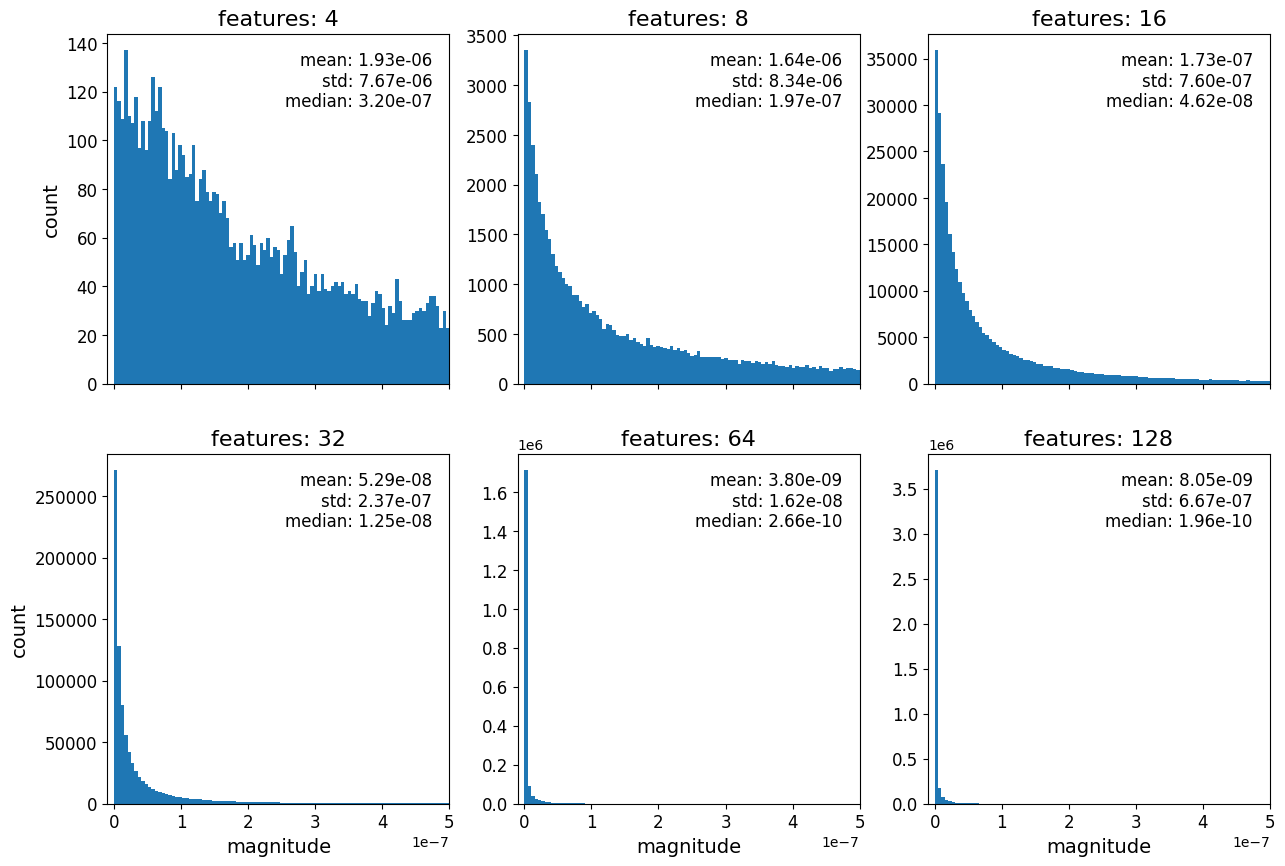

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
bins = np.linspace(0, 5e-7, 100)
ax = ax.flatten()
for i, key in enumerate(grads.keys()):
    ax[i].hist(np.abs(grads[key]), bins=bins, color='tab:blue')
    ax[i].set_title(f"features: {key}", fontsize=FONTSIZE+2)
    ax[i].set_xlim(-1e-8, 5e-7)
    ax[i].text(0.95, 0.95, f"mean: {np.mean(np.abs(grads[key])):.2e}\nstd: {err[i]:.2e}\nmedian: {y[i]:.2e}", transform=ax[i].transAxes, ha='right', va='top', fontsize=FONTSIZE-2)
    ax[i].tick_params(labelsize=FONTSIZE-2)
    
ax[0].set_ylabel('count', fontsize=FONTSIZE)
ax[3].set_ylabel('count', fontsize=FONTSIZE)
for i in range(3, 6):
    ax[i].set_xlabel('magnitude', fontsize=FONTSIZE)


In [6]:
fig.savefig('grad_study/grads_hist.pdf')